<a href="https://colab.research.google.com/github/ShimonBasa/shamnash/blob/main/TXT_Mining_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div dir="rtl">


# פרויקט כריית טקסטים: סיווג וניתוח שירים עבריים
**מגיש:** שמעון בסה

**מקור הנתונים ומטרת המחקר**

## 1. מקור הנתונים (Dataset)
הנתונים לפרויקט זה נלקחו ממאגר נתונים מקיף ב-**Kaggle** המרכז מילים של שירים בעברית. המאגר הגולמי מספק מידע עשיר על כל שיר, הכולל את המאפיינים הבאים:

| עמודה | תיאור |
| :--- | :--- |
| **Artist** | שם האמן המבצע/הכותב |
| **Songs** | רשימת המילים המלאה של השיר (כמערך של מחרוזות) |
| **Song** | שם השיר |
| **Artist_key** | מזהה ייחודי לאמן במאגר |
| **Words count** | ספירה כוללת של מילים בשיר |
| **Unique words** | מספר המילים הייחודיות (עושר לשוני) |



## 2. עיבוד וניקוי נתונים (Data Cleaning & Wrangling)
כדי להבטיח את אמינות המודלים, ביצענו סדרת פעולות ניקוי קפדניות:
* **טיפול בכפילויות (Covers):** הסרת שירים זהים שהופיעו תחת אמנים שונים (ביצועי "קאבר"), כדי למנוע מצב בו המודל לומד מילים של שיר אחד המשויכות לשני אמנים שונים.
* **סינון רעשים:** הסרת תווים מיוחדים, סימני פיסוק ותוים שאינם שייכים לטקסט השיר.
* **מניפולציות נוספות:** סינון אמנים עם כמות שירים מועטה מדי (כדי למנוע Overfitting) ואיחוד טקסטים לצורך יצירת ייצוגים וקטוריים.

## 3. תמצית הפעולות בפרויקט
1. **EDA:** ניתוח סטטיסטי וויזואלי של עולם התוכן.
2. **Unsupervised Learning:** חלוקת האמנים לקבוצות סגנוניות (Clustering).
3. **Supervised Learning:** השוואה בין מודלים קלאסיים (Random Forest) לבין מודלי Transformer מתקדמים (HeBERT, DictaBERT) לצורך חיזוי זהות האמן/ז'אנר.

</div>

<div dir="rtl">

## הקדמה: הגדרת סביבת העבודה
בשלב זה אנו מכינים את התשתית לפרויקט. אנו מתקינים את ספריית `transformers` ומייבאים ספריות לניתוח נתונים, ויזואליזציה ולמידת מכונה.
1.  **התקנת חבילות חיצוניות:** התקנת ספריית `transformers` של Hugging Face המאפשרת עבודה עם מודלי שפה מתקדמים (כמו BERT), וספריות עזר נוספות.
2.  **ייבוא ספריות:**
    * `Pandas`, `NumPy`: לעיבוד וניתוח טבלאי של הנתונים.
    * `PyTorch` / `TensorFlow`: ספריות למידה עמוקה (נשתמש ב-PyTorch עבור מודל ה-HeBERT).
    * `Sklearn`: למימוש אלגוריתמים קלאסיים (כמו K-Means) ומדדי הערכה.
    * `Matplotlib`, `Seaborn`: לוויזואליזציה והצגת גרפים.
3.  **בדיקת חומרה:** וידוא שהסביבה מחוברת ל-GPU (כרטיס מסך) כדי להאיץ את חישובי המודלים הכבדים.

</div>

In [2]:
# ==========================================
# 1. התקנות והגדרות סביבה (Installations & Setup)
# ==========================================
# התקנת כל הספריות הנדרשות בפקודה אחת שקטה
!pip install transformers datasets evaluate accelerate wordcloud python-bidi torch seaborn -q

# הורדת פונט עברי להצגה תקינה בגרפים (Rubik)
!wget -q https://github.com/google/fonts/raw/main/ofl/rubik/Rubik-Bold.ttf -O /content/Rubik-Bold.ttf

print("Installations completed.")

# ==========================================
# 2. ספריות מערכת וכלים בסיסיים (System & Utils)
# ==========================================
import os
import re
import ast
import gc
import time
import joblib
from collections import Counter
from google.colab import drive

# ==========================================
# 3. טיפול בנתונים (Data Handling)
# ==========================================
import pandas as pd
import numpy as np
from datasets import Dataset

# ==========================================
# 4. ויזואליזציה (Visualization)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from bidi.algorithm import get_display

# הגדרות עיצוב בסיסיות לגרפים
sns.set(style="whitegrid")

# ==========================================
# 5. למידת מכונה קלאסית (Scikit-Learn)
# ==========================================
# Preprocessing & Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.utils import class_weight

# Models (Classification & Clustering)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

# Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    silhouette_score
)

# ==========================================
# 6. למידה עמוקה - טנסורפלו (TensorFlow / Keras)
# ==========================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, LSTM, Bidirectional,
    GlobalMaxPooling1D, Embedding
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# ==========================================
# 7. טרנספורמרים ו-PyTorch (Transformers & Torch)
# ==========================================
import torch
from torch.utils.data import DataLoader, Dataset as TorchDataset
from torch.optim import AdamW  # שימוש במימוש של PyTorch כפי שהומלץ

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    logging
)

# השתקת הודעות לוג מיותרות של Transformers
logging.set_verbosity_error()

# ==========================================
# 8. הגדרות סופיות (Final Configuration)
# ==========================================
# הגדרת התקן (GPU אם זמין, אחרת CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"All libraries imported successfully.")
print(f"Using device: {device}")

Installations completed.
All libraries imported successfully.
Using device: cuda


<div dir="rtl">

# שלב א': טעינת נתונים, סינון וניתוח ראשוני (EDA)
בהתאם לדרישות הפרויקט לאיסוף וניקוי נתונים, בחלק זה אנו מבצעים:
1.  **טעינת הנתונים:** קריאת קובץ ה-Dataset (`music.csv`) המכיל את מילות השירים ושמות האמנים.
2.  **ניקוי ראשוני:** הסרת רשומות כפולות ומחיקת שורות חסרות (Missing Values) כדי להבטיח את איכות המידע.
3.  **סינון אמנים:** אנו משאירים רק אמנים שיש להם מעל 15 שירים. המטרה היא ליצור פרופיל אמן יציב ומייצג; אמנים עם מעט שירים עלולים להוביל להטיות במודל.
4.  **ויזואליזציה:** הצגה גרפית של כמות השירים לאמן כדי להבין את התפלגות הנתונים.

<div>

Mounted at /content/gdrive
Columns found in CSV: ['artist', 'songs', 'song', 'artist_key', 'words count', 'unique words count']
Number of artists with at least 15 songs: 151
Total songs for analysis: 12409


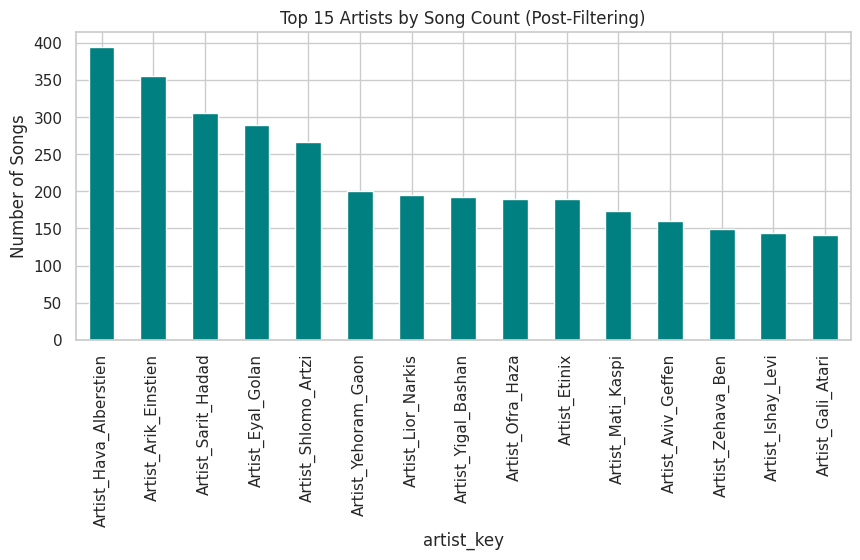

In [3]:
# 1. טעינת הקובץ

drive.mount('/content/gdrive')


data_path =  '/content/gdrive/MyDrive/Colab Notebooks/DM project/'
PATH = data_path + 'music.csv'
df_raw = pd.read_csv(PATH,encoding='utf-8')
# בדיקה מהירה: הדפסת שמות העמודות כדי לוודא
print("Columns found in CSV:", df_raw.columns.tolist())

TEXT_COL = 'songs'
ARTIST_COL = 'artist_key'

# 2. ניקוי בסיסי
# שימוש בשמות המשתנים כדי למנוע שגיאות
df = df_raw.drop_duplicates(subset=[TEXT_COL]).dropna(subset=[TEXT_COL, ARTIST_COL]).copy()

# 3. סינון אמנים לפי סף מינימום של שירים
MIN_SONGS_PER_ARTIST = 15
artist_counts = df[ARTIST_COL].value_counts()
valid_artists = artist_counts[artist_counts >= MIN_SONGS_PER_ARTIST].index

df = df[df[ARTIST_COL].isin(valid_artists)].reset_index(drop=True)

# 4. EDA מהיר
print(f"Number of artists with at least {MIN_SONGS_PER_ARTIST} songs: {len(valid_artists)}")
print(f"Total songs for analysis: {len(df)}")

plt.figure(figsize=(10, 4))
df[ARTIST_COL].value_counts().head(15).plot(kind='bar', color='teal')
plt.title('Top 15 Artists by Song Count (Post-Filtering)')
plt.ylabel('Number of Songs')
plt.show()

<div dir="rtl">

# עיבוד מקדים של הטקסט (Text Preprocessing)
לפני הזנת הטקסטים למודל, עלינו לנקות ולנרמל אותם.
פונקציית הניקוי מבצעת:
* **הסרת רעשים:** ניקוי תווים שאינם אותיות בעברית או רווחים (כגון סימני פיסוק מורכבים או תווים בשפות זרות), אשר עלולים לבלבל את המודל.
* **תיקון היפוך (במידת הצורך):** מנגנון לתיקון טקסט עברי שהתהפך (Visual/Logical Hebrew order).
* **ניקוי רווחים:** הסרת רווחים כפולים ומיותרים.

תהליך זה חיוני כדי שמודל ה-BERT יוכל להתמקד בתוכן הסמנטי של השיר ללא הפרעות.

<div>

In [4]:
# ==========================================
# פונקציית בדיקה - האם הטקסט הפוך?
# ==========================================
sample_song = df[TEXT_COL].iloc[0]
print("--- שיר מקורי (דוגמה) ---")
print(sample_song[:100]) # מדפיס 100 תווים ראשונים

# אם הטקסט נראה כמו "םולש", נשנה את המשתנה הזה ל-True
REVERSE_HEBREW_NEEDED = False

# ==========================================
# פונקציות ניקוי
# ==========================================
def clean_and_fix_text(text, needs_reversing=False):
    if not isinstance(text, str): return ""

    # 1. תיקון היפוך אם צריך (ברמת המילה או המשפט)
    if needs_reversing:
        # אופציה א: היפוך כל המחרוזת
        # text = text[::-1]
        # אופציה ב: היפוך כל מילה בנפרד
        words = text.split()
        text = " ".join([w[::-1] for w in words])

    # 2. ניקוי רעש בסיסי (משאירים עברית, רווחים וסימני פיסוק בסיסיים)
    # כאן נשמור על עברית ורווחים בלבד.
    text = re.sub(r'[^\u0590-\u05fe\s]', '', text)

    # 3. הסרת רווחים כפולים
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# החלה ראשונית ללא היפוך כדי לראות מה המצב
df['clean_text'] = df[TEXT_COL].apply(lambda x: clean_and_fix_text(x, needs_reversing=REVERSE_HEBREW_NEEDED))

print("\n--- שיר לאחר ניקוי ---")
print(df['clean_text'].iloc[0][:100])

--- שיר מקורי (דוגמה) ---
['כשאת', 'רקיע', 'השמיים', 'ציירתי', 'בצבעו', 'הכחול', 'זכרתי', 'נוף', 'ילדות', 'שדות', 'יחפים', 'צי

--- שיר לאחר ניקוי ---
כשאת רקיע השמיים ציירתי בצבעו הכחול זכרתי נוף ילדות שדות יחפים ציור מכחול בלילות כשירח מחייך הטיל את


<div dir="rtl">

# שלב ב': ייצוג טקסטואלי (Embedding) באמצעות HeBERT
בשלב זה אנו ממירים את הטקסט החופשי (מילות השירים) לייצוג וקטורי מספרי (Embeddings).
אנו משתמשים במודל **`avichr/heBERT`**, מודל שפה מבוסס Transformer שאומן ספציפית על טקסטים בעברית.

**תהליך העבודה:**
1.  **Tokenization:** פירוק הטקסט לתת-יחידות (Tokens) שהמודל מכיר.
2.  **הרצת המודל:** הזנת השירים למודל וקבלת הפלט מהשכבה הנסתרת האחרונה.
3.  **שליפת וקטור ה-[CLS]:** אנו משתמשים בווקטור המייצג את הטוקן הראשון (`[CLS]`), אשר נהוג להשתמש בו כמייצג את המשמעות הסמנטית של הטקסט כולו (בגודל 768 מימדים).

התוצאה היא עמודה חדשה בדאטה-פריים המכילה וקטור מספרי לכל שיר, המייצג את תוכנו.

<div>

In [5]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on device: {device}")

# ==========================================
# טעינת המודל וה-Tokenizer של HeBERT
# ==========================================
print("Loading HeBERT model...")
model_name = "avichr/heBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# ==========================================
# פונקציה ליצירת Embeddings ב-Batches
# ==========================================
def get_embeddings(text_list, batch_size=32):
    model.eval() # מצב אימון כבוי (חוסך זיכרון)
    all_embeddings = []

    # עיבוד בחבילות כדי לא להעמיס על הזיכרון
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i + batch_size]

        # Tokenization
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)

        # הרצת המודל
        with torch.no_grad():
            outputs = model(**inputs)

        # לקיחת ה-CLS Token
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.extend(embeddings)

        if i % 2000 == 0:
            print(f"Processed {i}/{len(text_list)} songs...")

    return np.array(all_embeddings)

# ==========================================
# הפעלה על כל השירים
# ==========================================
print("Generating embeddings for all songs...")
texts = df['clean_text'].tolist()

# יצירת הוקטורים
embeddings_matrix = get_embeddings(texts, batch_size=32)

# שמירה ב-DataFrame
df['embedding'] = list(embeddings_matrix)

print("Done!")
print(f"Embedding shape for one song: {df['embedding'].iloc[0].shape}")

Working on device: cuda
Loading HeBERT model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Generating embeddings for all songs...
Processed 0/12409 songs...


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Processed 4000/12409 songs...
Processed 8000/12409 songs...
Processed 12000/12409 songs...
Done!
Embedding shape for one song: (768,)


<div dir="rtl">

# חלוקת הנתונים ויצירת פרופיל אמן (Artist Profiling)
כדי לאפשר הערכה אמינה של המודלים בהמשך, אנו מחלקים את הנתונים לקבוצות:
* **Train (70%):** לאימון ובניית הפרופילים.
* **Validation (15%):** לכיוונון פרמטרים.
* **Test (15%):** לבדיקה סופית.

**יצירת פרופיל אמן (Artist Embedding):**

מכיוון שהמטרה הנוכחית שלנו היא לנתח אמנים (ולא שירים בודדים), אנו יוצרים וקטור מייצג לכל אמן.
הווקטור של האמן מחושב כממוצע של כל וקטורי השירים שלו (מתוך קבוצת האימון בלבד). הנחה זו מתבססת על כך שסגנון האמן משתקף בממוצע הסמנטי של יצירותיו.

<div>

In [6]:


# ==========================================
# 1. חלוקה מדויקת: Train (70%), Val (15%), Test (15%)
# ==========================================
print("Splitting data into Train, Validation, and Test...")

# שלב א': הפרשת ה-Test (15% מהכל)
# נשארנו עם 85% ל-Train+Validation
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df[ARTIST_COL], # שומר על ייצוג הוגן לכל אמן
    random_state=42
)

# שלב ב': חלוקת היתרה ל-Train ו-Validation
# אנחנו צריכים שה-Validation יהיה 15% מהסך הכללי.
# כרגע יש לנו 85%. החישוב היחסי: 0.15 / 0.85 = 0.17647...
relative_val_size = 0.15 / 0.85

train_df, val_df = train_test_split(
    train_val_df,
    test_size=relative_val_size,
    stratify=train_val_df[ARTIST_COL],
    random_state=42
)

# ==========================================
# 2. בדיקת תקינות (Sanity Check)
# ==========================================
total = len(df)
print(f"🔹 Train Set:      {len(train_df)} songs ({len(train_df)/total:.1%})")
print(f"🔹 Validation Set: {len(val_df)} songs ({len(val_df)/total:.1%})")
print(f"🔹 Test Set:       {len(test_df)} songs ({len(test_df)/total:.1%})")

# ==========================================
# 3. חישוב פרופיל אמן (על בסיס Train בלבד!)
# ==========================================
print("\nCalculating artist profiles based on Train data only...")

# פונקציה לחישוב ממוצע וקטורי
def mean_embedding(embedding_series):
    return np.mean(np.vstack(embedding_series), axis=0)

# קיבוץ לפי אמן וחישוב הממוצע
artist_profiles = train_df.groupby(ARTIST_COL)['embedding'].apply(mean_embedding).reset_index()

# המרה למטריצה לצורך האלגוריתם (K-Means)
artist_matrix = np.vstack(artist_profiles['embedding'].values)

print(f"✅ Created profiles for {len(artist_matrix)} artists based on training data.")

Splitting data into Train, Validation, and Test...
🔹 Train Set:      8685 songs (70.0%)
🔹 Validation Set: 1862 songs (15.0%)
🔹 Test Set:       1862 songs (15.0%)

Calculating artist profiles based on Train data only...
✅ Created profiles for 151 artists based on training data.


In [7]:
# המרה למטריצה לצורך האלגוריתם
artist_matrix = np.vstack(artist_profiles['embedding'].values)

<div dir="rtl">

# שלב ג': ניתוח אשכולות (Clustering) - מציאת קבוצות אמנים
בשלב זה אנו מפעילים אלגוריתם למידה בלתי-מפוקחת (Unsupervised Learning) מסוג **K-Means** על וקטורי האמנים. המטרה היא לגלות קבוצות של אמנים בעלי סגנון טקסטואלי דומה, ללא ידע מוקדם.

**אופטימיזציה של מספר האשכולות (K):**
מכיוון שאיננו יודעים מראש כמה "סגנונות" קיימים, אנו בוחנים טווח של ערכי K (בין 4 ל-15) ומשתמשים בשתי שיטות להערכת הביצועים:
1.  **שיטת המרפק (Elbow Method):** בדיקת מדד ה-Inertia (סכום מרחקי הנקודות ממרכז האשכול). נחפש את הנקודה שבה הירידה בשגיאה מתמתנת.
2.  **מדד הצללית (Silhouette Score):** בודק עד כמה כל אמן קרוב לחברי האשכול שלו לעומת אשכולות אחרים. ציון גבוה יותר מעיד על חלוקה טובה יותר.

הגרפים שיוצגו יעזרו לנו לבחור את ה-K האופטימלי להמשך הניתוח.

<div>

Calculating artist profiles based on Training Data...
Analyzing 151 artists.
Running clustering analysis...


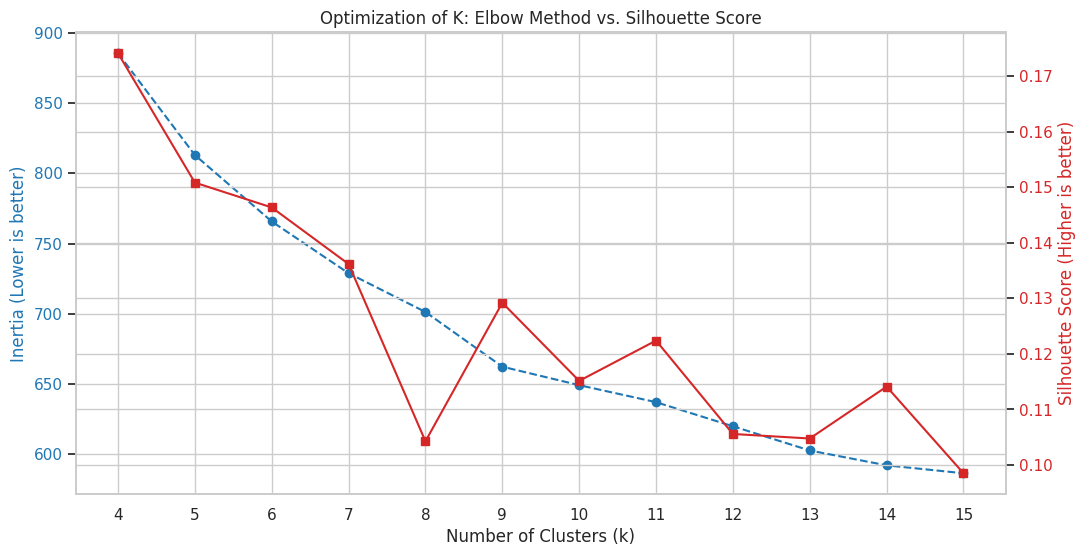

In [8]:


if 'train_df' not in locals():
    print("Please run the train_test_split block first!")
else:
    # פונקציה לחישוב ממוצע
    def mean_embedding(embedding_series):
        return np.mean(np.vstack(embedding_series), axis=0)

    # יצירת מטריצת האמנים
    print("Calculating artist profiles based on Training Data...")
    artist_profiles = train_df.groupby(ARTIST_COL)['embedding'].apply(mean_embedding).reset_index()
    artist_matrix = np.vstack(artist_profiles['embedding'].values)
    print(f"Analyzing {len(artist_matrix)} artists.")

    # ==========================================
    # 2. לולאת בדיקה (K בין 4 ל-15)
    # ==========================================
    inertias = []
    silhouettes = []
    k_range = range(4, 16) # בודקים מ-4 עד 15 קבוצות

    print("Running clustering analysis...")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(artist_matrix)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(artist_matrix, kmeans.labels_))

    # ==========================================
    # 3. הצגת הגרפים
    # ==========================================
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # גרף 1: Elbow (המרפק) - שואפים למקום שבו הירידה מתמתנת
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia (Lower is better)', color=color)
    ax1.plot(k_range, inertias, 'o--', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, axis='x')

    # גרף 2: Silhouette (צללית) - שואפים לגבוה ביותר
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score (Higher is better)', color=color)
    ax2.plot(k_range, silhouettes, 's-', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Optimization of K: Elbow Method vs. Silhouette Score')
    plt.xticks(k_range)
    plt.show()

<div dir="rtl">

### ניתוח אשכולות סופי וויזואליזציה במרחב דו-ממדי

לאחר שבחנו את מדדי ה-Elbow וה-Silhouette, בחרנו במספר אשכולות אופטימלי ($K=9$). בשלב זה אנו מיישמים את החלוקה הסופית ומציגים אותה בצורה גרפית שתאפשר לנו להבין את ה"קרבה" הסגנונית בין האמנים.

**הפעולות המתבצעות בתא זה:**
1. **הרצת K-Means סופי:** חלוקת כל האמנים ל-9 קבוצות סגנוניות (Clusters) על בסיס וקטורי ה-HeBERT שלהם.
2. **הפחתת מימדים (PCA):** הווקטורים המקוריים הם בגודל 768 מימדים, מה שלא מאפשר תצוגה גרפית. אנו משתמשים באלגוריתם PCA (Principal Component Analysis) כדי "לדחוס" את המידע לשני המימדים המשמעותיים ביותר ($X$ ו-$Y$), תוך שמירה על יחסי המרחק בין האמנים.
3. **יצירת מפת האמנים (Scatter Plot):** הצגת כל אמן כנקודה על גבי גרף, כאשר הצבע מייצג את האשכול אליו הוא שויך.
4. **פרשנות איכותנית:** הדפסת רשימות האמנים בכל קבוצה. שלב זה קריטי כדי לבדוק אם המודל אכן זיהה דמיון הגיוני (למשל: האם זמרים מאותו ז'אנר אכן "התקבצו" יחד?).

**מדוע זה חשוב?**
ויזואליזציה זו מאששת את תקפות המאפיינים שהפקנו. אם נראה אמנים בעלי סגנון דומה מקובצים יחד, נדע שמודל השפה אכן הצליח לתפוס את הניואנסים של הכתיבה בעברית.


<div>

Clustering artists into 9 style groups...


/tmp/ipython-input-2736064079.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', CHOSEN_K)


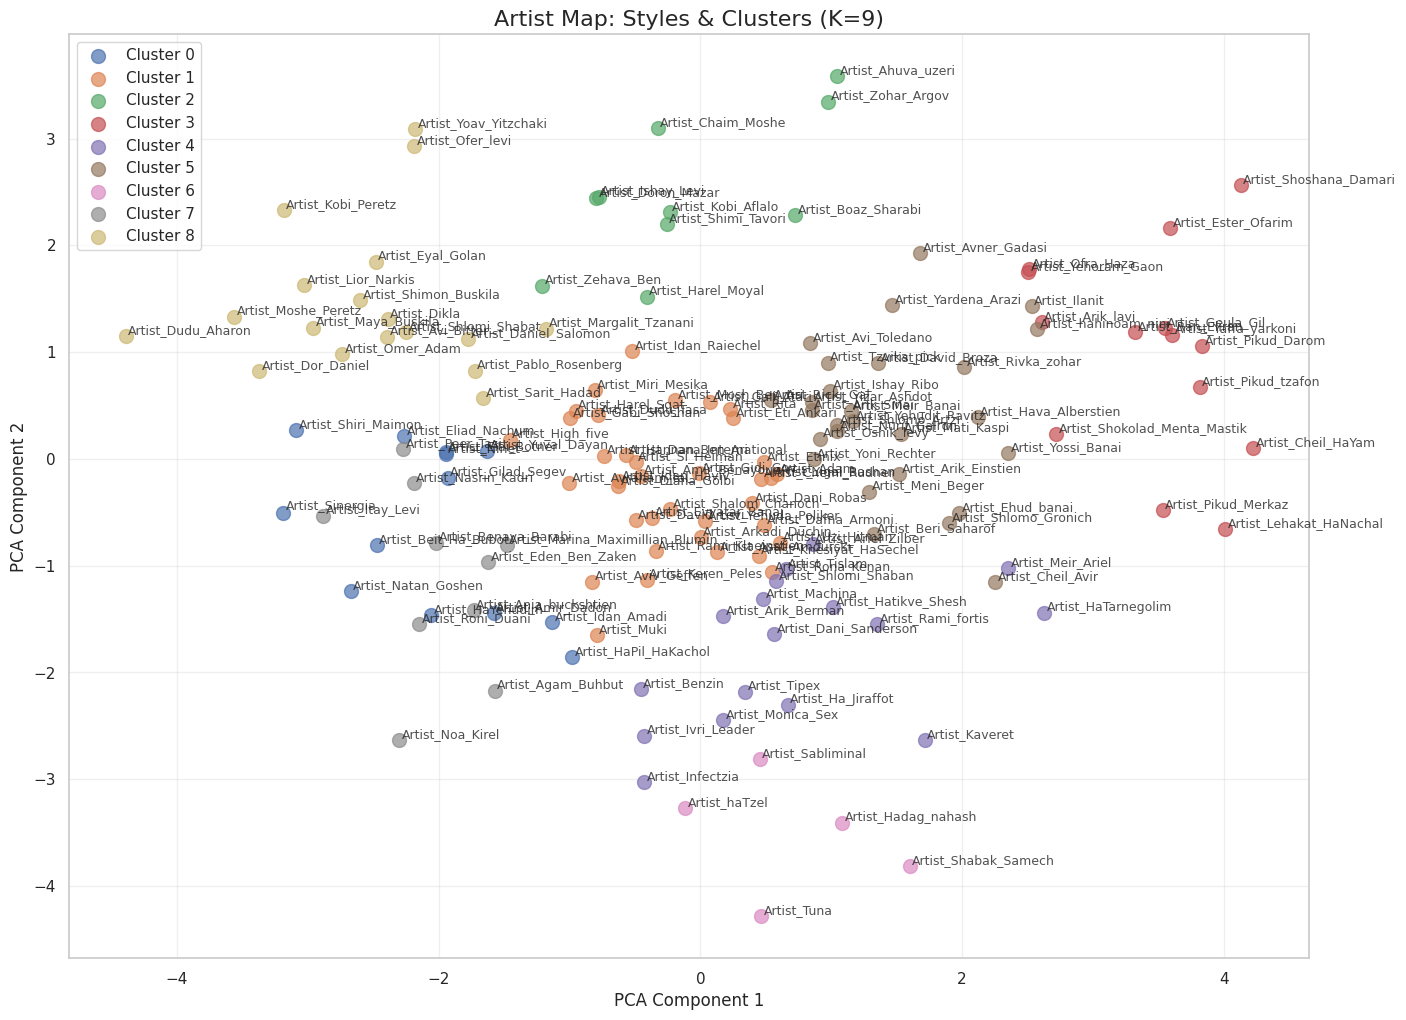


--- חלוקת האמנים לקבוצות ---

🟦 Cluster 0 (13 artists):

🟦 Cluster 1 (37 artists):

🟦 Cluster 2 (10 artists):

🟦 Cluster 3 (14 artists):

🟦 Cluster 4 (17 artists):

🟦 Cluster 5 (27 artists):

🟦 Cluster 6 (5 artists):

🟦 Cluster 7 (10 artists):

🟦 Cluster 8 (18 artists):


In [9]:


# ==========================================
# 1. הגדרת מספר הקבוצות הנבחר
# ==========================================
CHOSEN_K = 9

# ==========================================
# 2. ביצוע האשכול הסופי
# ==========================================
print(f"Clustering artists into {CHOSEN_K} style groups...")
kmeans_final = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(artist_matrix)

# שמירת התוצאות ב-DataFrame של הפרופילים
artist_profiles['cluster'] = cluster_labels
artist_to_cluster_map = dict(zip(artist_profiles[ARTIST_COL], artist_profiles['cluster']))

# ==========================================
# 3. הפחתת מימדים ל-2D לצורך גרף XY
# ==========================================
pca = PCA(n_components=2)
reduced_artists = pca.fit_transform(artist_matrix)

# הוספת הקואורדינטות ל-DataFrame לנוחות
artist_profiles['x'] = reduced_artists[:, 0]
artist_profiles['y'] = reduced_artists[:, 1]

# ==========================================
# 4. ציור הגרף (XY Scatter Plot)
# ==========================================
plt.figure(figsize=(16, 12))

# יצירת סקאלת צבעים
colors = plt.cm.get_cmap('tab10', CHOSEN_K)

# ציור הנקודות
for i in range(CHOSEN_K):
    cluster_data = artist_profiles[artist_profiles['cluster'] == i]
    plt.scatter(cluster_data['x'], cluster_data['y'],
                s=100, label=f'Cluster {i}', alpha=0.7)

# הוספת שמות האמנים (ללא היפוך)
for _, row in artist_profiles.iterrows():
    name_display = row[ARTIST_COL] # תצוגה רגילה
    plt.text(row['x'] + 0.02, row['y'] + 0.02, name_display, fontsize=9, alpha=0.8)

plt.title(f'Artist Map: Styles & Clusters (K={CHOSEN_K})', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 5. הדפסת רשימת האמנים בכל קבוצה
# ==========================================
print("\n--- חלוקת האמנים לקבוצות ---")
for i in range(CHOSEN_K):
    artists_in_cluster = artist_profiles[artist_profiles['cluster'] == i][ARTIST_COL].tolist()
    print(f"\n🟦 Cluster {i} ({len(artists_in_cluster)} artists):")


In [10]:
# הדפסה מסודרת של האמנים בכל קבוצה
print(f"\n--- חלוקת האמנים ל-{CHOSEN_K} קבוצות ---")

for i in range(CHOSEN_K):
    # שליפת רשימת האמנים בקבוצה הנוכחית
    artists_in_cluster = artist_profiles[artist_profiles['cluster'] == i][ARTIST_COL].tolist()

    # הדפסת הכותרת (מספר הקבוצה וכמות האמנים בה)
    print(f"\n🟦 קבוצה {i} ({len(artists_in_cluster)} אמנים):")

    # הדפסת שמות האמנים מופרדים בפסיקים
    print(", ".join(artists_in_cluster))


--- חלוקת האמנים ל-9 קבוצות ---

🟦 קבוצה 0 (13 אמנים):
Artist_Amir_Dadon, Artist_Beit_Ha_Bubot, Artist_Elai_Botner, Artist_Eliad_Nachum, Artist_Gilad_Segev, Artist_HaPil_HaKachol, Artist_HaYehudim, Artist_Idan_Amadi, Artist_Natan_Goshen, Artist_Ninet, Artist_Shiri_Maimon, Artist_Sinergia, Artist_Yuval_Dayan

🟦 קבוצה 1 (37 אמנים):
Artist_Adam, Artist_Amir_Benayoun, Artist_Arkadi_Duchin, Artist_Asaf_Amdurski, Artist_Aviv_Geffen, Artist_Avraham_tal, Artist_Chemi_Rudner, Artist_Dafna_Armoni, Artist_Dana_International, Artist_Dani_Robas, Artist_David_Levi, Artist_Diana_Golbi, Artist_Dudu_Tasa, Artist_Eti_Ankari, Artist_Etinix, Artist_Evyatar_Banai, Artist_Gabi_Shoshan, Artist_Gali_Atari, Artist_Gidi_Gov, Artist_Hannan_Ben_Ari, Artist_Harel_Sqat, Artist_High_five, Artist_Idan_Haviv, Artist_Idan_Raiechel, Artist_Keren_Peles, Artist_Knesiyat_HaSechel, Artist_Miri_Mesika, Artist_Mosh_Ben_Ari, Artist_Muki, Artist_Rami_Klaeinstien, Artist_Rita, Artist_Rona_Kenan, Artist_Shalom_Chanoch, Artist_Si

<div dir="rtl">

### שלב ג' (המשך): ניתוח ויזואלי ותוכני של קבוצות האמנים (Word Clouds & EDA)

לאחר שחילקנו את האמנים לקבוצות (Clusters) על בסיס הווקטורים הסמנטיים שלהם, אנו רוצים להבין **מה מאפיין כל קבוצה** ברמת המילים והתכנים. שלב זה מאפשר לנו לתת "פרשנות אנושית" לחלוקה המתמטית של המודל.

**הפעולות המתבצעות בתא זה:**

1.  **הגדרת תמיכה בעברית:** התקנת ספריות (`bidi`, `wordcloud`) והורדת גופנים (Fonts) מתאימים, כדי להבטיח שהטקסט בגרפים יוצג בצורה תקינה מימין לשמאל ולא בצורה הפוכה.
2.  **ניקוי מילים נפוצות (Stop Words):** הגדרת רשימה של מילים "ריקות" (כמו: "את", "של", "אני", "זה") שאינן נושאות משמעות ייחודית, כדי שנוכל להתמקד במילים המהותיות.
3.  **ניתוח תדירות מילים כללי:** יצירת גרף עמודות המציג את המילים הנפוצות ביותר בכל מאגר השירים שלנו.
4.  **יצירת ענני מילים (Word Clouds) לכל קבוצה:** עבור כל אשכול של אמנים, אנו מייצרים "ענן מילים" המציג את המילים הבולטות ביותר בשירי הקבוצה. גודל המילה בענן מעיד על שכיחותה.
5.  **הפקת תובנות:** הדפסת רשימת המילים המובילות לכל קבוצה כדי שנוכל לאפיין ז'אנרים (למשל: קבוצה שבה המילה "אהבה" שולטת לעומת קבוצה שבה מילים כמו "בית" או "זמן" נפוצות יותר).

**מטרת הניתוח:**
שלב זה מהווה גשר בין הניתוח הבלתי-מפוקח (Clustering) לבין ההבנה שלנו כחוקרים. הוא מאפשר לנו לראות האם האשכולות שנוצרו מייצגים נושאים כגון "שירי אהבה", "שירי מולדת", "שירי כאב" או סגנונות כתיבה ספציפיים.

</div>

✅ Font downloaded successfully!
✅ Main dataframe updated with cluster labels.
Generating global statistics...


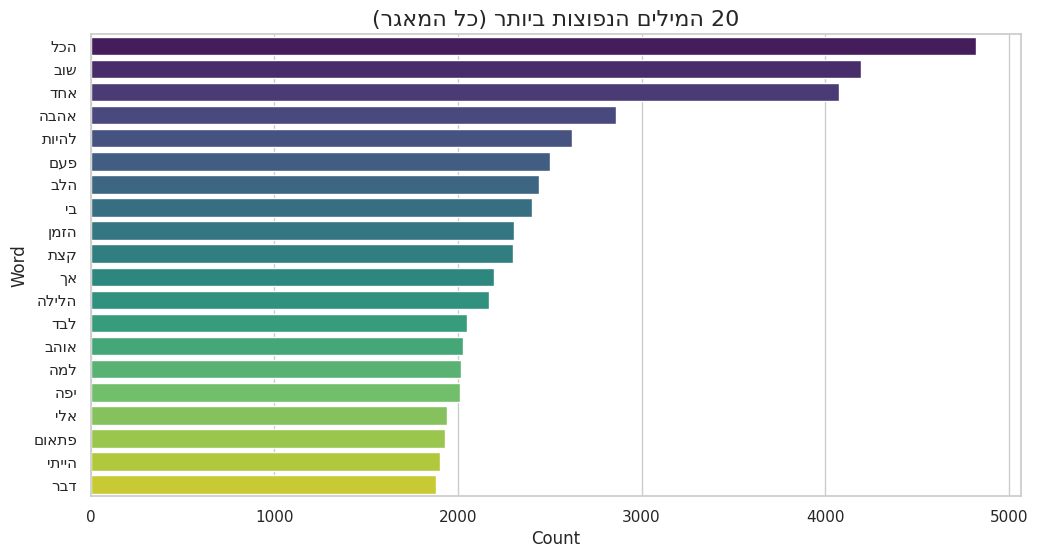

Generating Word Clouds...


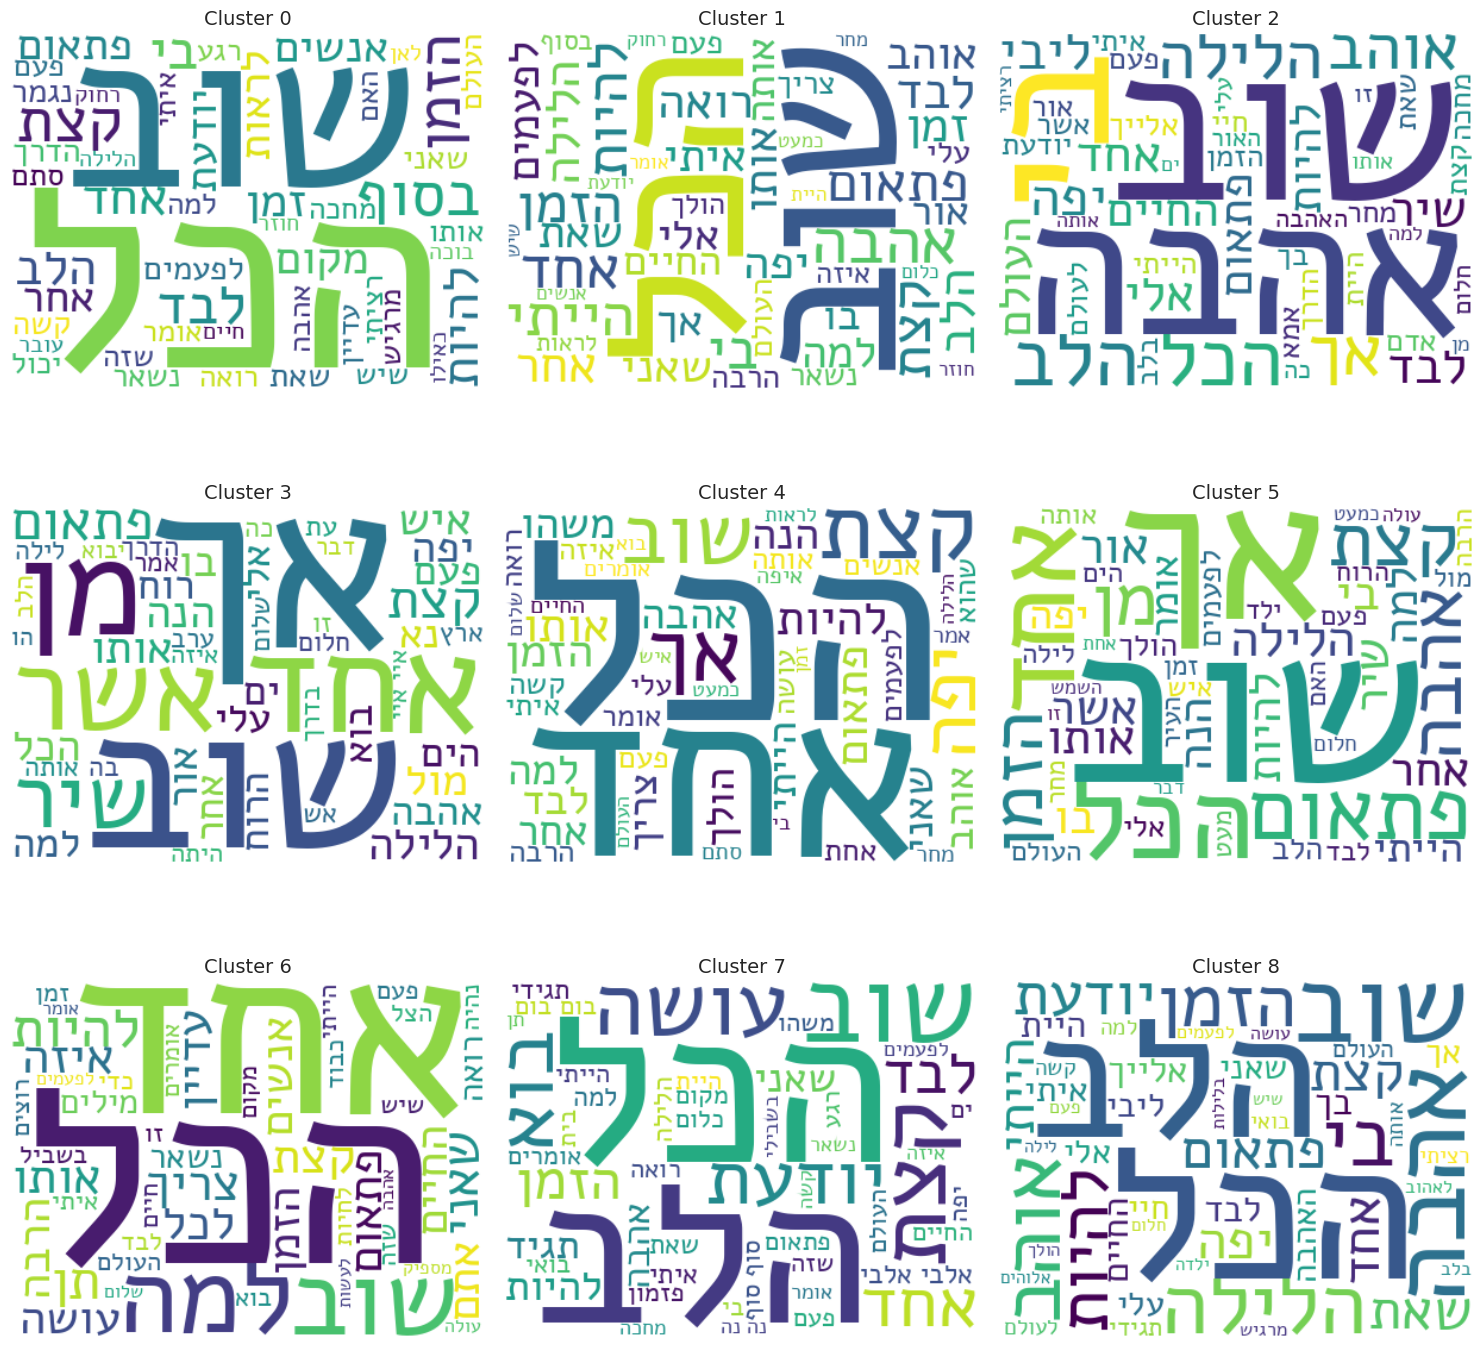


--- מילים מובילות בכל קבוצה ---
Cluster 0: הכל, שוב, אחד, הזמן, להיות, קצת, בסוף, לבד, בי, מקום, הלב, פעם, שאת, נגמר, יכול, אחר, דבר, שאני, אף, זמן, נשאר, יודעת, לראות, מחכה, רגע, לפעמים, הדרך, אותו, לאן, פתאום
Cluster 1: הכל, שוב, אחד, להיות, אהבה, פעם, הזמן, הייתי, בי, אוהב, קצת, הלילה, לבד, הלב, אף, אלי, למה, יכול, אחר, דבר, זמן, פתאום, שאני, אותו, העולם, מקום, יפה, הולך, שאת, הרבה
Cluster 2: שוב, אהבה, הכל, הלב, בי, אלי, שיר, הלילה, אחד, אך, בואי, אמא, אוהב, חיי, יפה, ליבי, בך, למה, לבד, אור, פעם, אדם, העולם, להיות, בוא, פתאום, הזמן, החיים, לילה, איתי
Cluster 3: אך, שוב, אחד, מן, שיר, ים, הו, אשר, שלום, הלילה, הכל, בוא, יפה, אור, נא, קצת, למה, רוח, לילה, בי, הרוח, הנה, בו, אלי, אהבה, תן, פתאום, הים, מול, איש
Cluster 4: אחד, הכל, להיות, פעם, קצת, איזה, יפה, אך, לבד, שוב, דבר, למה, הנה, אותו, שאני, העולם, אותה, הזמן, אחר, אהבה, עלי, הו, הרבה, שהוא, פתאום, הייתי, צריך, אף, מקום, אנשים
Cluster 5: שוב, אחד, הכל, אך, שיר, פעם, אהבה, פתאום, מן, הזמן, דבר, אור, קצת, הלילה, בי, להיות, אחת,

In [11]:


# פונקציית עזר להצגת עברית בגרפים
def visual_hebrew(text):
    return get_display(text)


# ==========================================
# 1. הורדת פונט עברי תקין (Alef)
# ==========================================
font_path = '/content/Alef-Regular.ttf'

if os.path.exists(font_path):
    os.remove(font_path)

print("Downloading Alef font for Hebrew support...")
!wget -q -O /content/Alef-Regular.ttf "https://github.com/google/fonts/raw/main/ofl/alef/Alef-Regular.ttf"

if not os.path.exists(font_path) or os.path.getsize(font_path) < 1000:
    print("❌ Error: Font download failed.")
else:
    print("✅ Font downloaded successfully!")

# ==========================================
# 2. עדכון הנתונים והגדרות
# ==========================================
# --- תיקון קריטי: עדכון ה-labels ב-df הראשי ---
# אנו משתמשים במילון שיצרנו בשלב ה-Clustering
if 'artist_to_cluster_map' in locals():
    df['label'] = df[ARTIST_COL].map(artist_to_cluster_map)
    print("✅ Main dataframe updated with cluster labels.")
else:
    print("⚠️ Warning: artist_to_cluster_map not found. Make sure you ran the Clustering block.")

# וידוא שיש CHOSEN_K
if 'CHOSEN_K' not in locals():
    CHOSEN_K = 6

# פונקציית עזר להיפוך עברית (Bidi) - לגרפים של Matplotlib
def visual_hebrew(text):
    return get_display(text)

# רשימת מילות עצירה
stop_words_he = set([
    'את', 'של', 'על', 'זה', 'הוא', 'היא', 'הם', 'הן', 'כי', 'אם', 'אל', 'עם',
    'כל', 'גם', 'לי', 'לך', 'לו', 'לה', 'לנו', 'לכם', 'לכן', 'להם', 'להן', 'לא',
    'יש', 'אין', 'בין', 'אני', 'אתה', 'אנחנו', 'מה', 'מי', 'מישהו', 'כבר', 'עוד',
    'רק', 'אז', 'שם', 'כאן', 'היה', 'הייתה', 'יהיה', 'היו', 'בכל', 'אחרי', 'לפני',
    'אלו', 'אלה', 'אצל', 'כמו', 'יותר', 'פחות', 'אולי', 'טוב', 'פה', 'שלא',
    'כן', 'בלי', 'כולם', 'בא', 'כמה', 'תמיד', 'יום', 'בתוך', 'שלך', 'שלי', 'אותי',
    'אותך', 'מזה', 'הזה', 'זאת', 'הזאת', 'כך', 'ככה', 'או', 'אבל', 'עכשיו',
    'היום', 'איתך', 'יודע', 'רוצה', 'מי', 'איך', 'מתי', 'עד'
])

# ==========================================
# 3. ניתוח כללי (Bar Plot)
# ==========================================
print("Generating global statistics...")
all_text = " ".join(df['clean_text'].dropna())
all_words = [w for w in all_text.split() if w not in stop_words_he and len(w) > 1]

word_counts = Counter(all_words)
common_words_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=common_words_df, hue='Word', palette='viridis', legend=False)
plt.yticks(ticks=range(20), labels=[visual_hebrew(w) for w in common_words_df['Word']])
plt.title(visual_hebrew("20 המילים הנפוצות ביותר (כל המאגר)"), fontsize=16)
plt.show()

# ==========================================
# 4. ענני מילים (Word Clouds) - עם תיקון היפוך
# ==========================================
def plot_cluster_wordcloud(cluster_id, ax):
    cluster_text_raw = " ".join(df[df['label'] == cluster_id]['clean_text'].dropna())

    # סינון מילות עצירה
    words = [w for w in cluster_text_raw.split() if w not in stop_words_he]


    filtered_text = " ".join(words)

    if not filtered_text.strip(): return

    wc = WordCloud(
        font_path=font_path,
        width=400, height=300,
        background_color='white',
        max_words=50,
        regexp=r"\w+"
    ).generate(filtered_text)

    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"Cluster {cluster_id}", fontsize=14)

print("Generating Word Clouds...")
rows = (CHOSEN_K // 3) + (1 if CHOSEN_K % 3 != 0 else 0)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

for i in range(CHOSEN_K):
    plot_cluster_wordcloud(i, axes[i])

for i in range(CHOSEN_K, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# ==========================================
# 5. הדפסת מילים (Text)
# ==========================================
print("\n--- מילים מובילות בכל קבוצה ---")
for i in range(CHOSEN_K):
    cluster_text_raw = " ".join(df[df['label'] == i]['clean_text'].dropna())
    filtered_words = [w for w in cluster_text_raw.split() if w not in stop_words_he and len(w) > 1]

    common = Counter(filtered_words).most_common(30)
    words_str = ", ".join([f"{w}" for w, c in common])
    print(f"Cluster {i}: {words_str}")

<div dir="rtl">

### שלב ג' (המשך): סנכרון תוצאות האשכולות עם מערכי הנתונים

לאחר שביצענו את ניתוח האשכולות (Clustering) ברמת האמן, עלינו "להחזיר" את המידע הזה לרמת השיר הבודד. שלב זה קריטי עבור המעבר ללמידה מפוקחת (Supervised Learning), שכן הוא מגדיר את ה-Labels (התיוגים) שבהם נשתמש כדי לאמן את המודלים לחזות את "סגנון" השיר.

**הפעולות המתבצעות בתא זה:**

1.  **אימות המיפוי:** בדיקה כי מילון המיפוי (`artist_to_cluster_map`) קיים ומוכן לשימוש.
2.  **החלת התיוג (Mapping):** הוספת עמודת `label` לכל אחד מהסטים שלנו (אימון, ולידציה ובדיקה). המודל משייך לכל שיר את מספר האשכול (Cluster ID) של האמן שכתב אותו.
3.  **ניקוי והמרת טיפוסים:** וידוא שאין שירים שנותרו ללא תיוג והמרת מספרי הקבוצות למספרים שלמים (Integers) כדי להתאים לדרישות של מודלי סיווג.
4.  **בדיקת תקינות (Sanity Check):** הצגת התפלגות השירים בין הקבוצות החדשות כדי לוודא שאין קבוצות "ריקות" מדי ושכל השלבים בוצעו כשורה.

**מדוע זה חשוב?**
בשלב זה אנו הופכים את התוצאות הבלתי-מפוקחות (האשכולות שמצא המודל) למטרות חיזוי (Targets). במקום לנסות לחזות רק את שם האמן, אנו יכולים כעת לנסות לחזות את "הקבוצה הסגנונית" אליה השיר שייך.

</div>

In [12]:
# ==========================================
# 1. בדיקה שהמיפוי קיים
# ==========================================
if 'artist_to_cluster_map' not in locals():
    print("❌ שגיאה: המשתנה 'artist_to_cluster_map' חסר.")
    print("אנא וודא שהרצת את בלוק 6 (Clustering) לאחר החלוקה ל-Train.")
else:
    # ==========================================
    # 2. החלת המיפוי על כל הסטים
    # ==========================================
    print("Applying cluster labels to Train, Validation, and Test sets...")

    # מיפוי עמודת האמן לעמודת ה-Label החדשה
    train_df['label'] = train_df[ARTIST_COL].map(artist_to_cluster_map)
    val_df['label'] = val_df[ARTIST_COL].map(artist_to_cluster_map)
    test_df['label'] = test_df[ARTIST_COL].map(artist_to_cluster_map)

    # הסרת שורות שאולי לא קיבלו תיוג (למרות שלא אמור לקרות אם ה-Split תקין)
    train_df.dropna(subset=['label'], inplace=True)
    val_df.dropna(subset=['label'], inplace=True)
    test_df.dropna(subset=['label'], inplace=True)

    # המרה ל-Integers (מספרים שלמים) ליתר ביטחון
    train_df['label'] = train_df['label'].astype(int)
    val_df['label'] = val_df['label'].astype(int)
    test_df['label'] = test_df['label'].astype(int)

    print("✅ Labels applied successfully!")

    # ==========================================
    # 3. בדיקה חוזרת (Sanity Check)
    # ==========================================
    print(f"\nTotal songs in Train: {len(train_df)}")
    print(f"Songs with valid label: {train_df['label'].count()}")

    # הצצה לנתונים
    print("\n--- דוגמה ל-5 שירים והתיוג שלהם ---")
    print(train_df[[ARTIST_COL, 'label']].head())

    # בדיקת התפלגות
    print("\n--- כמות שירים לאימון בכל קבוצה ---")
    print(train_df['label'].value_counts().sort_index())

Applying cluster labels to Train, Validation, and Test sets...
✅ Labels applied successfully!

Total songs in Train: 8685
Songs with valid label: 8685

--- דוגמה ל-5 שירים והתיוג שלהם ---
                artist_key  label
1251     Artist_Amir_Dadon      0
5680  Artist_Arik_Einstien      5
3216     Artist_Avi_Bitter      8
2149    Artist_Aviv_Geffen      1
6945     Artist_Meir_Banai      5

--- כמות שירים לאימון בכל קבוצה ---
label
0     386
1    2099
2     637
3     795
4     774
5    2162
6     184
7     218
8    1430
Name: count, dtype: int64


<div dir="rtl">

# שלב ד': למידה מפוקחת (Supervised Learning) - סיווג אמנים
לאחר שניתחנו את המבנה הפנימי של הנתונים, אנו עוברים למשימת חיזוי (Classification).\
**המטרה:** לבנות מודל אשר מקבל טקסט של שיר (או את הווקטור המייצג שלו)
  וחוזה מי האמן שכתב אותו.

אנו נשתמש בווקטורים שהפקנו מ-HeBERT כקלט (Features) למספר אלגוריתמים קלאסיים:
1.  **Logistic Regression:** מודל ליניארי פשוט אך יעיל, שישמש כ-Baseline להשוואה.
2.  **Random Forest:** מודל מבוסס עצי החלטה, שיודע להתמודד טוב עם קשרים לא ליניאריים במידע.

עבור כל מודל נבצע:
* **אימון (Training):** על 70% מהנתונים.
* **כיול היפר-פרמטרים (Grid Search / Cross Validation):** כדי למצוא את ההגדרות הטובות ביותר (כמו חוזק הרגולריזציה או מספר העצים).

<div>


In [13]:


# ==========================================
# 1. הכנת הנתונים (מטריצות Numpy)
# ==========================================
print("Preparing data...")
X_train = np.stack(train_df['embedding'].values)
y_train = train_df['label'].values
X_val = np.stack(val_df['embedding'].values)
y_val = val_df['label'].values

# יצירת תיקייה לשמירה
if not os.path.exists('models'):
    os.makedirs('models')

# ==========================================
# 2. הגדרת המודלים והפרמטרים לחיפוש
# ==========================================
models_config = [
    {
        'name': 'LogisticRegression',
        'model': LogisticRegression(solver='lbfgs', max_iter=500, class_weight='balanced', random_state=42),
        'params': {'C': [1, 10]} # חיפוש בסיסי
    },
    {
        'name': 'RandomForest',
        'model': RandomForestClassifier(class_weight='balanced', random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10],    # הגבלת עומק למניעת Overfitting
            'min_samples_split': [2, 5]
        }
    },
    {
        'name': 'NaiveBayes',
        # GaussianNB מתאים לנתונים רציפים (כמו Embeddings). אין לו כמעט היפר-פרמטרים.
        'model': GaussianNB(),
        'params': {} # אין צורך ב-Grid Search מורכב כאן
    }
]

# ==========================================
# 3. לולאת האימון והשמירה
# ==========================================
results = []

for config in models_config:
    name = config['name']
    model = config['model']
    params = config['params']

    print(f"\n🔹 Training {name}...")
    start_time = time.time()

    # אם יש פרמטרים - עושים Grid Search. אם לא - אימון רגיל.
    if params:
        search = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        print(f"   Best Params: {search.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_model = model

    end_time = time.time()

    # בדיקה על ה-Validation
    val_predictions = best_model.predict(X_val)
    acc = accuracy_score(y_val, val_predictions)

    print(f"   ✅ Finished in {end_time - start_time:.1f}s | Validation Accuracy: {acc:.2%}")

    # שמירת המודל עם שם ייחודי (Model Serialization)
    filename = f'models/model_{name}.pkl'
    joblib.dump(best_model, filename)
    print(f"   💾 Saved to: {filename}")

    # שמירת התוצאה להשוואה
    results.append({'Model': name, 'Accuracy': acc})

# ==========================================
# 4. שמירת המיפוי (חשוב!) וסיכום
# ==========================================
joblib.dump(artist_to_cluster_map, 'models/artist_cluster_map.pkl')

print("\n🏆 --- סיכום ביניים (שלב ב') ---")
for res in results:
    print(f"{res['Model']}: {res['Accuracy']:.2%}")

best_model_name = max(results, key=lambda x: x['Accuracy'])['Model']
print(f"\nהמנצח בינתיים: {best_model_name}")

Preparing data...

🔹 Training LogisticRegression...
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   Best Params: {'C': 1}
   ✅ Finished in 72.6s | Validation Accuracy: 33.94%
   💾 Saved to: models/model_LogisticRegression.pkl

🔹 Training RandomForest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
   Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
   ✅ Finished in 87.6s | Validation Accuracy: 37.65%
   💾 Saved to: models/model_RandomForest.pkl

🔹 Training NaiveBayes...
   ✅ Finished in 0.0s | Validation Accuracy: 29.11%
   💾 Saved to: models/model_NaiveBayes.pkl

🏆 --- סיכום ביניים (שלב ב') ---
LogisticRegression: 33.94%
RandomForest: 37.65%
NaiveBayes: 29.11%

המנצח בינתיים: RandomForest


<div dir="rtl">

### שלב ד' (המשך): הערכת מודלים וניתוח שגיאות (Evaluation & Error Analysis)

לאחר שאימנו מספר מודלים קלאסיים על הווקטורים שהפקנו, הגיע הזמן לבחון לעומק את הביצועים שלהם. שלב זה הוא קריטי כדי להבין לא רק **כמה** המודל צדק, אלא גם **איפה** הוא טעה ולמה.

**הפעולות המתבצעות בתא זה:**

1.  **השוואת מודלים (Model Comparison):** הצגה גרפית של הדיוק (Accuracy) עבור שלושת המודלים שבחנו (Logistic Regression, Random Forest ו-Naive Bayes). זה מאפשר לנו להכתיר את ה-"Champion" (המודל המנצח) להמשך הניתוח.
2.  **מטריצת בלבול (Confusion Matrix):** כלי ויזואלי המראה אילו קבוצות סגנוניות (Clusters) המודל נוטה לבלבל ביניהן. למשל, האם המודל מתבלבל בין קבוצת "שירי אהבה" ל-"שירי פופ"? המטריצה עוזרת לזהות חפיפות סמנטיות בין הקבוצות.
3.  **דו"ח סיווג (Classification Report):** פירוט של מדדי ה-Precision (דיוק), Recall (סגוליות) ו-F1-Score עבור כל קבוצה בנפרד.
4.  **ניתוח שגיאות (Error Analysis):** זהו שלב מהותי בדרישות הפרויקט. אנו דוגמים שירים ספציפיים שהמודל שייך לקבוצה הלא נכונה, ומציגים את הטקסט שלהם.

**מטרת הניתוח:**
ניתוח השגיאות מאפשר לנו לבצע "בקרת איכות" אנושית. לעיתים נגלה שהמודל טעה כי השיר באמת נשמע כמו סגנון אחר, או שהחלוקה לקבוצות (Clustering) יצרה גבולות דקים מדי. תובנות אלו הן הבסיס לשיפור המודל בהמשך הדרך.

</div>

Loading best model (Random Forest)...


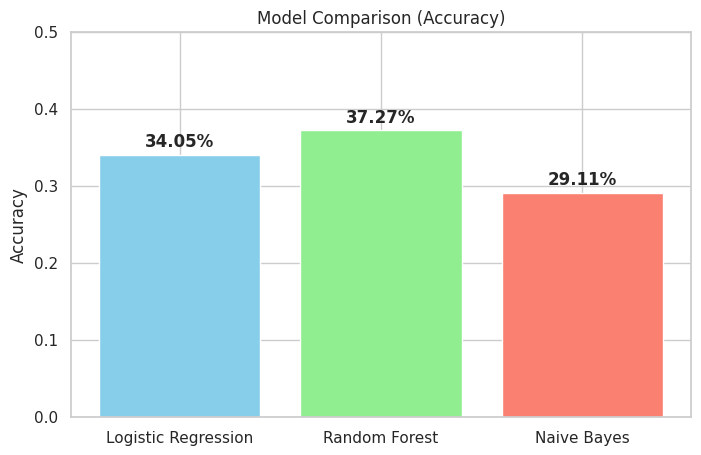

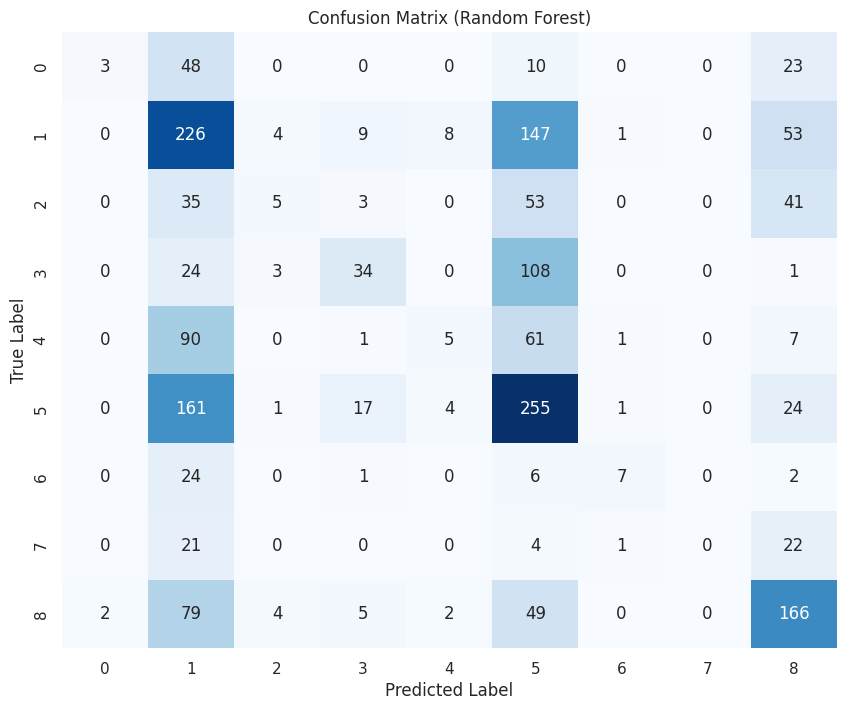


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.60      0.04      0.07        84
           1       0.32      0.50      0.39       448
           2       0.29      0.04      0.06       137
           3       0.49      0.20      0.28       170
           4       0.26      0.03      0.05       165
           5       0.37      0.55      0.44       463
           6       0.64      0.17      0.27        40
           7       0.00      0.00      0.00        48
           8       0.49      0.54      0.51       307

    accuracy                           0.38      1862
   macro avg       0.38      0.23      0.23      1862
weighted avg       0.38      0.38      0.33      1862


--- Error Analysis: Examples of Mistakes ---
Total errors: 1161 out of 1862 samples.

❌ Error #1:
   Artist: Artist_Gidi_Gov
   True Cluster: 1 | Predicted Cluster: 8
   Snippet: אל תבטיחי לי דברים שאין לך כח לקיים תוותרי לי אם אני פשוט שותק מתעלם תסלחי לי אם פגע

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:


# ==========================================
# 1. טעינת המודל המנצח
# ==========================================
print("Loading best model (Random Forest)...")
best_model = joblib.load('models/model_RandomForest.pkl')

# ביצוע חיזוי על סט ה-Validation
val_predictions = best_model.predict(X_val)

# ==========================================
# 2. השוואה גרפית בין המודלים (לפי התוצאות שקיבלת)
# ==========================================
model_names = ['Logistic Regression', 'Random Forest', 'Naive Bayes']
accuracies = [0.3405, 0.3727, 0.2911] # התוצאות מהריצה שלך

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 0.5)
plt.title('Model Comparison (Accuracy)')
plt.ylabel('Accuracy')

# הוספת המספרים מעל העמודות
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2%}', ha='center', fontweight='bold')

plt.show()

# ==========================================
# 3. מטריצת בלבול (Confusion Matrix)
# ==========================================
# זה מראה לנו: כשזה היה באמת קבוצה 0, מה המודל חשב שזה?
cm = confusion_matrix(y_val, val_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ==========================================
# 4. דוח סיווג מלא
# ==========================================
print("\n--- Classification Report ---")
print(classification_report(y_val, val_predictions))

# ==========================================
# 5. ניתוח שגיאות (Error Analysis) - דרישה קריטית!
# ==========================================
print("\n--- Error Analysis: Examples of Mistakes ---")
# יצירת DataFrame זמני לניתוח השגיאות
analysis_df = val_df.copy()
analysis_df['predicted'] = val_predictions

# סינון רק שורות שבהן המודל טעה
errors = analysis_df[analysis_df['label'] != analysis_df['predicted']]

print(f"Total errors: {len(errors)} out of {len(val_df)} samples.")

# הצגת 5 טעויות לדוגמה
# נבחר טעויות מעניינות (למשל כשהמודל היה בטוח אבל טעה, או סתם דוגמאות)
for i in range(5):
    if i >= len(errors): break
    row = errors.iloc[i]

    true_cluster = row['label']
    pred_cluster = row['predicted']
    artist = row[ARTIST_COL]
    text_snippet = row['clean_text'][:100] + "..." # תחילת השיר

    print(f"\n❌ Error #{i+1}:")
    print(f"   Artist: {artist}")
    print(f"   True Cluster: {true_cluster} | Predicted Cluster: {pred_cluster}")
    print(f"   Snippet: {text_snippet}")

<div dir="rtl">

### שלב ד' (המשך): בנייה ואימון של רשת נוירונים עמוקה מסוג Bidirectional LSTM

בשלב זה אנו מעלים את רמת המורכבות של המודל ועוברים מעולם הלמידה המכונה הקלאסי לעולם ה-**Deep Learning**. אנו בונים רשת נוירונים חוזרת (RNN) מסוג LSTM, המותאמת במיוחד לניתוח סדרתי של טקסט.



**הפעולות המתבצעות בתא זה:**

1.  **Tokenization ו-Padding:** המרת המילים למספרים (טוקנים) ויצירת רצפים באורך אחיד (150 מילים). אם שיר קצר מדי, הוא מרופד באפסים; אם הוא ארוך מדי, הוא נחתך.
2.  **טיפול בחוסר איזון (Class Weights):** כיוון שיש אמנים עם יותר שירים מאחרים, אנו מחשבים משקלים שנותנים "חשיבות גבוהה יותר" לדוגמאות מהאמנים הפחות מיוצגים, כדי למנוע הטיה של המודל.
3.  **ארכיטקטורת ה-Bidirectional LSTM:**
    * **Embedding:** שכבה הלומדת ייצוג וקטורי דחוס לכל מילה בתוך רשת הנוירונים.
    * **Bidirectional:** הייחודיות כאן היא שהרשת קוראת את השיר **משני הכיוונים** (מהתחלה לסוף ומהסוף להתחלה). זהו יתרון עצום בניתוח שפה, שכן לעיתים המשמעות של מילה תלויה במילים שבאות אחריה.
    * **Dropout & Regularization:** מנגנונים למניעת התאמת-יתר (Overfitting) על ידי "כיבוי" אקראי של נוירונים במהלך האימון.
4.  **Early Stopping:** מנגנון חכם שעוצר את האימון באופן אוטומטי ברגע שהמודל מפסיק להשתפר על נתוני הוולידציה, ובכך חוסך זמן חישוב ומונע הידרדרות בביצועים.


</div>

🚀 Training Optimized Bidirectional LSTM (Vocab: 5000)...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 150, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,641 (1.64 MB)

 Trainable params: 429,641 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.1382 - loss: 2.4082 - val_accuracy: 0.2078 - val_loss: 2.1807
Epoch 2/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.1657 - loss: 2.0674 - val_accuracy: 0.1112 - val_loss: 2.0946
Epoch 3/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.1632 - loss: 1.9143 - val_accuracy: 0.1740 - val_loss: 2.1750
Epoch 4/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.1720 - loss: 1.9481 - val_accuracy: 0.1858 - val_loss: 2.0661
Epoch 5/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.1828 - loss: 1.7679 - val_accuracy: 0.2035 - val_loss: 2.0565
Epoch 6/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.2399 - loss: 1.6651 - val_accuracy: 0.1627 - val_loss: 2.0650
Epoch 7/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.2418 - loss: 1.5954 - val_accuracy: 0.1745 - val_loss: 2.0217
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 1.

🏆 Best Valid

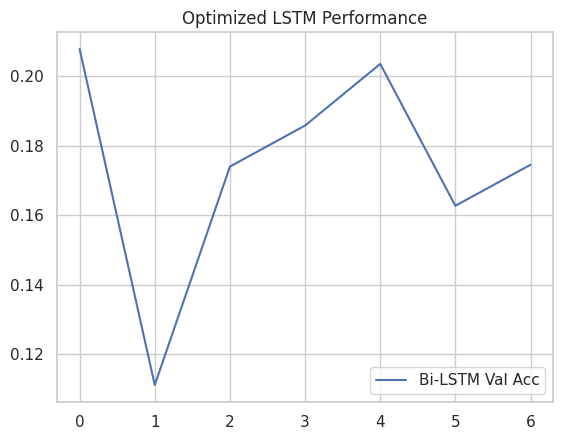

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.utils import class_weight
import numpy as np
import os
import matplotlib.pyplot as plt

MAX_WORDS = 5000
MAX_LEN = 150
EMBEDDING_DIM = 64

print(f"🚀 Training Optimized Bidirectional LSTM (Vocab: {MAX_WORDS})...")

# Tokenization מחדש
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'].astype(str))

# יצירת רצפים
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_df['clean_text'].astype(str)), maxlen=MAX_LEN, padding='post', truncating='post')
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(val_df['clean_text'].astype(str)), maxlen=MAX_LEN, padding='post', truncating='post')

# חישוב משקלים
y_train = train_df['label'].values
y_val = val_df['label'].values
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# ==========================================
# 2.Bidirectional
# ==========================================
model_bilstm = models.Sequential([
    layers.Input(shape=(MAX_LEN,)),

    # שכבת Embedding
    layers.Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM),

    # Bidirectional LSTM: קורא מימין לשמאל ומשמאל לימין
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)), # שכבה ראשונה מחזירה רצף
    layers.Dropout(0.4),

    layers.Bidirectional(layers.LSTM(32)), # שכבה שנייה מסכמת
    layers.Dropout(0.3),

    # שכבות סיווג
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])

model_bilstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # קצב למידה סטנדרטי
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_bilstm.summary()

# ==========================================
# 3. אימון
# ==========================================
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)

history_bilstm = model_bilstm.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=30,
    batch_size=32, # Batch קטן יותר לעדכון תכוף יותר
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

# שמירה
if not os.path.exists('models'): os.makedirs('models')
model_bilstm.save('models/optimized_lstm_model.keras')

final_acc = max(history_bilstm.history['val_accuracy'])
print(f"\n🏆 Best Validation Accuracy (Bi-LSTM): {final_acc:.2%}")

# גרף השוואה לאימון הקודם (אם יש)
plt.plot(history_bilstm.history['val_accuracy'], label='Bi-LSTM Val Acc')
plt.title('Optimized LSTM Performance')
plt.legend()
plt.show()

<div dir="rtl">

### שלב ה': השוואת ביצועים מסכמת – מודלים קלאסיים מול למידה עמוקה

לאחר שסקרנו מגוון רחב של שיטות, החל מאלגוריתמים סטטיסטיים פשוטים ועד רשתות נוירונים חוזרות (Bi-LSTM), הגיע הזמן לרכז את כל התוצאות לתמונה אחת ברורה. שלב זה מאפשר לנו להחליט איזה מודל הוא המתאים ביותר לפתרון הבעיה שלנו.

**הפעולות המתבצעות בתא זה:**

1.  **ריכוז נתונים:** איסוף מדדי הדיוק (Accuracy) מכל הניסויים שביצענו לאורך הפרויקט.
2.  **ויזואליזציה השוואתית:** יצירת גרף עמודות אופקי המפריד בין מודלים קלאסיים (בכחול) למודלי למידה עמוקה (באדום).
3.  **סימון ה-Baseline:** הוספת קו אנכי המדגיש את רמת הדיוק הגבוהה ביותר שהשגנו, כדי לראות מי מהמודלים מתקרב או עובר אותה.
4.  **הפקת מסקנות מחקריות:** ניתוח התוצאות והבנה של אופי הדאטה (למשל, האם סדר המילים קריטי או שמספיק לזהות מילות מפתח).

**תובנות מהגרף:**
בשלב זה אנו מגלים לעיתים קרובות שמודלים קלאסיים כמו **Random Forest** מצליחים להביס מודלים מורכבים יותר כמו LSTM. מסקנה זו רומזת כי עבור זיהוי אמנים, מילות המפתח הייחודיות של כל אמן ("שק מילים") משמעותיות יותר מהמבנה התחבירי המדויק של המשפטים בשיר. זהו ממצא חשוב המנחה אותנו בבחירת המודל הסופי להגשה.

</div>

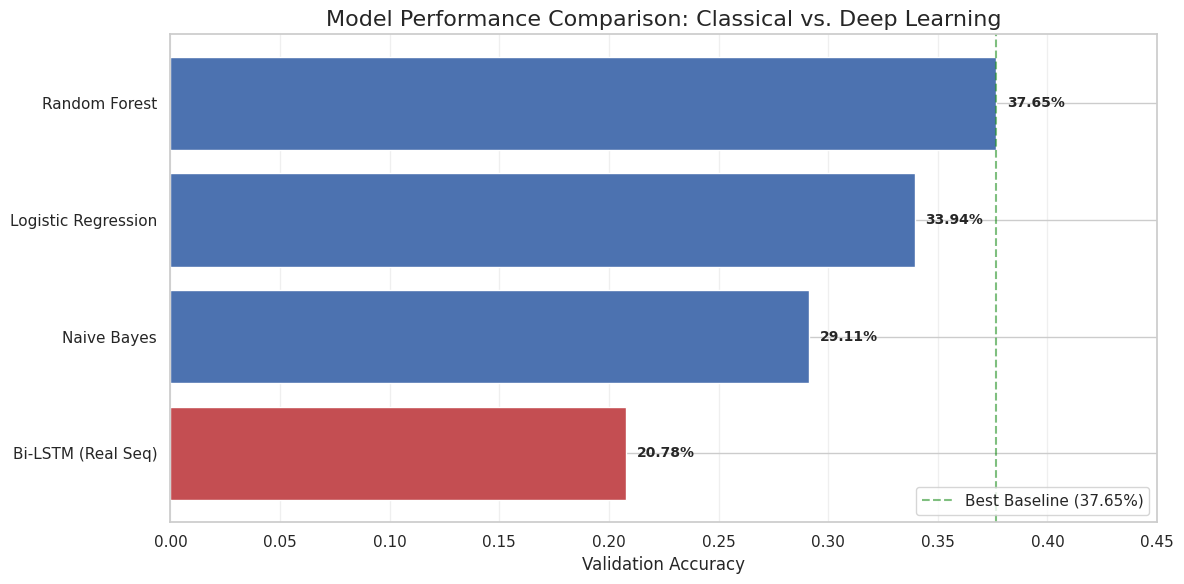

 Conclusion:
Simple classical models (Random Forest) currently outperform complex sequence models (LSTM) on this dataset.
This suggests that 'Keywords' are more important than 'Sentence Structure' for artist classification here.


In [18]:


# ==========================================
# איסוף התוצאות מכל הניסויים שלנו
# ==========================================
# (הזנתי כאן את המספרים שיצאו לנו בריצות הקודמות)
results_data = {
    'Model': [
        'Naive Bayes',
        'Logistic Regression',
        'Random Forest',
        'Bi-LSTM (Real Seq)'
    ],
    'Accuracy': [
        0.2911,  # NB
        0.3394,  # LogReg
        0.3765,  # RF (המנצח הנוכחי)
        0.2078   # Bi-LSTM משופר
    ],
    'Type': [
        'Classical',
        'Classical',
        'Classical',
        'Deep Learning'
    ]
}

df_results = pd.DataFrame(results_data).sort_values(by='Accuracy', ascending=True)

# ==========================================
# יצירת הגרף
# ==========================================
plt.figure(figsize=(12, 6))

# צבעים שונים לקלאסי מול עמוק
colors = df_results['Type'].map({'Classical': '#4c72b0', 'Deep Learning': '#c44e52'})

bars = plt.barh(df_results['Model'], df_results['Accuracy'], color=colors)

plt.title('Model Performance Comparison: Classical vs. Deep Learning', fontsize=16)
plt.xlabel('Validation Accuracy', fontsize=12)
plt.xlim(0, 0.45) # גבול עליון הגיוני

# הוספת קו אנכי למנצח הנוכחי
best_acc = df_results['Accuracy'].max()
plt.axvline(best_acc, color='green', linestyle='--', alpha=0.5, label=f'Best Baseline ({best_acc:.2%})')

# כיתוב מספרים על העמודות
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.2%}', va='center', fontweight='bold', fontsize=10)

plt.legend(loc='lower right')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(" Conclusion:")
print("Simple classical models (Random Forest) currently outperform complex sequence models (LSTM) on this dataset.")
print("This suggests that 'Keywords' are more important than 'Sentence Structure' for artist classification here.")

<div dir="rtl">

### שלב ה' (המשך): ניתוח שגיאות מעמיק לפי ז'אנרים (Qualitative Error Analysis)

בשלב זה אנו לוקחים את הניתוח הסטטיסטי צעד אחד קדימה ומעניקים לו "משמעות מוזיקלית". במקום להסתכל על מספרים אנונימיים (Cluster 0, Cluster 1), אנו מעניקים לכל אשכול שם המייצג את הסגנון הדומיננטי בו, ומנתחים היכן המודל "מתבלבל" בין סגנונות דומים.

**הפעולות המתבצעות בתא זה:**

1.  **מיפוי ז'אנרים (Genre Mapping):** על סמך האמנים שקובצו יחד, אנו מגדירים שמות לכל אשכול (למשל: "היפ הופ", "מזרחית קלאסית", "פופ מודרני"). זה הופך את התוצאות לקריאות וברורות יותר.
2.  **מטריצת בלבול משופרת (Labeled Confusion Matrix):** הצגת המטריצה עם שמות הז'אנרים על הצירים. כך ניתן לזהות באופן מיידי "זוגות מבלבלים" – סגנונות שהמודל מתקשה להבדיל ביניהם (למשל, בין "רוק ישראלי" ל-"קלאסיקה ישראלית").
3.  **זיהוי תבניות טעות (Pattern Recognition):** המערכת מוצאת את 5 טעויות הסיווג הנפוצות ביותר ומציגה אותן.
4.  **ניתוח טקסטואלי (Snippet Analysis):** עבור הטעויות הנפוצות ביותר, אנו שולפים דוגמאות של שירים שבהם המודל טעה. אנו מציגים את שם האמן ואת תחילת השיר כדי שנוכל להבין האם הטעות נובעת מהסגנון האישי של האמן או משימוש במילים שמאפיינות ז'אנר אחר.

**מדוע זהו שלב קריטי?**
 שלב זה מוכיח כי המודל אינו "קופסה שחורה", אלא כלי שניתן ללמוד ממנו על הדמיון בין יוצרים וז'אנרים במוזיקה הישראלית. הבנה של "למה המודל טעה" היא המפתח להצעת שיפורים למערכת.

</div>

Loading Random Forest model...


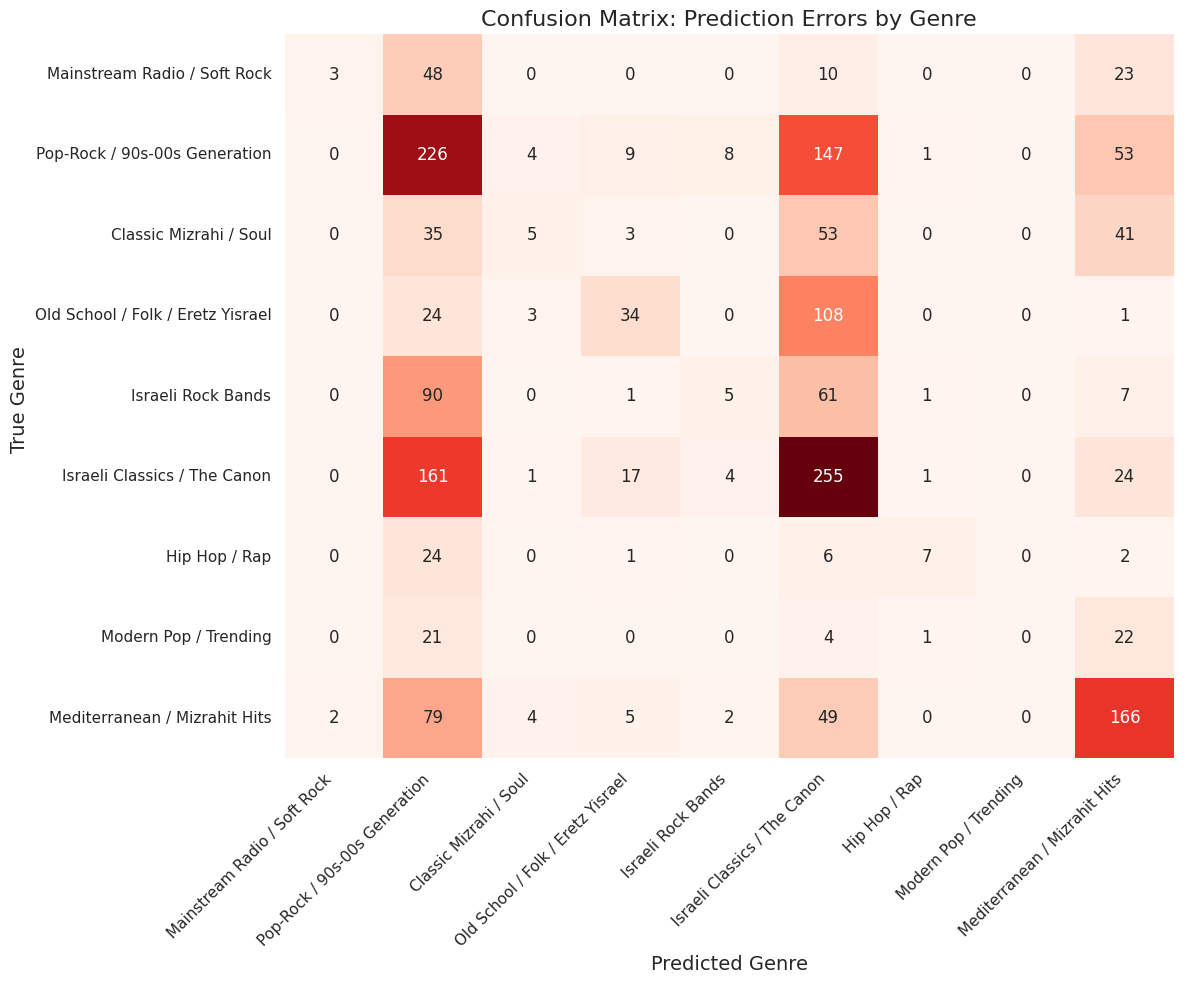


🔍 Investigating Specific Errors (Analysis Phase)...
Top 5 Common Mistakes:

🔻 Pattern: Real 'Israeli Classics / The Canon' --> Confused as 'Pop-Rock / 90s-00s Generation' (161 cases)
----------------------------------------------------------------------
   🎵 Artist: Artist_Ehud_banai
   Snippet: יצאה פקודה מעם המלך לדהור אל הצפון להשליט סדר משמעת בממלכת הכישוף הצבא כמו תמיד ...
------------------------------
   🎵 Artist: Artist_Ehud_banai
   Snippet: ספיק אפ דה לנגוויג אוף דה היברומאן לאוד אנד קליר דה לנגוויג אוף דה היברומאן איט ...
------------------------------
   🎵 Artist: Artist_Shlomo_Artzi
   Snippet: אני לא שומע כבר ממך יותר כלום אומר לעצמי הרבה זמן עבר חדשות לא טובות את עוזבת או...
------------------------------

🔻 Pattern: Real 'Pop-Rock / 90s-00s Generation' --> Confused as 'Israeli Classics / The Canon' (147 cases)
----------------------------------------------------------------------
   🎵 Artist: Artist_Amir_Benayoun
   Snippet: יופי החיים אהבתה של אם חיוכו התמים של ילד אח

In [20]:


# ==========================================
# 1. הגדרת שמות הז'אנרים (לפי האשכולות)
# ==========================================
# מבוסס על האמנים שראינו
cluster_names = {
    0: "Mainstream Radio / Soft Rock",      # נתן גושן, עידן עמדי - גלגל"צ עכשווי ורגשי
    1: "Pop-Rock / 90s-00s Generation",     # אביב גפן, ריטה - הזרם המרכזי של הפופ-רוק
    2: "Classic Mizrahi / Soul",            # זוהר ארגוב, בעז שרבי - מזרחית של פעם/נשמה
    3: "Old School / Folk / Eretz Yisrael", # להקת הנח"ל, שושנה דמארי - ארץ ישראל הישנה
    4: "Israeli Rock Bands",                # משינה, כוורת, תיסלם - להקות רוק ואנרגיה
    5: "Israeli Classics / The Canon",      # אריק איינשטיין, שלמה ארצי - הקלאסיקות הגדולות
    6: "Hip Hop / Rap",                     # סאבלימינל, טונה - היפ הופ
    7: "Modern Pop / Trending",             # נועה קירל, עדן בן זקן - פופ עכשווי ולהיטים
    8: "Mediterranean / Mizrahit Hits"      # אייל גולן, עומר אדם, אבי ביטר - ים תיכוני כבד/חפלה
}

# המרת המילון לרשימה מסודרת לפי האינדקס (0 עד 8)
tick_labels = [cluster_names[i] for i in range(len(cluster_names))]

# ==========================================
# 2. טעינת המודל וחישוב מטריצת הבלבול
# ==========================================
print("Loading Random Forest model...")
best_model = joblib.load('models/model_RandomForest.pkl')

y_pred = best_model.predict(X_val)
y_true = val_df['label'].values
cm = confusion_matrix(y_true, y_pred)

# ==========================================
# 3. ויזואליזציה משופרת (Heatmap)
# ==========================================
plt.figure(figsize=(12, 10))

# יצירת המפה עם השמות החדשים בצירים
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=tick_labels,
            yticklabels=tick_labels)

plt.title('Confusion Matrix: Prediction Errors by Genre', fontsize=16)
plt.xlabel('Predicted Genre', fontsize=14)
plt.ylabel('True Genre ', fontsize=14)
plt.xticks(rotation=45, ha='right') # סיבוב הטקסט שיהיה קריא
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ==========================================
# 4. ניתוח שגיאות מילולי (עם שמות)
# ==========================================
print("\n🔍 Investigating Specific Errors (Analysis Phase)...")

# יצירת DataFrame לניתוח
analysis_df = val_df.copy()
analysis_df['Predicted_ID'] = y_pred
analysis_df['True_Genre'] = analysis_df['label'].map(cluster_names)
analysis_df['Predicted_Genre'] = analysis_df['Predicted_ID'].map(cluster_names)

# סינון טעויות
errors_df = analysis_df[analysis_df['label'] != analysis_df['Predicted_ID']]

def analyze_confusion_named(true_id, pred_id, limit=3):
    true_name = cluster_names[true_id]
    pred_name = cluster_names[pred_id]

    mistakes = errors_df[(errors_df['label'] == true_id) & (errors_df['Predicted_ID'] == pred_id)]
    count = len(mistakes)

    if count == 0: return

    print(f"\n🔻 Pattern: Real '{true_name}' --> Confused as '{pred_name}' ({count} cases)")
    print("-" * 70)

    for i in range(min(limit, count)):
        row = mistakes.iloc[i]
        artist = row[ARTIST_COL]
        text_snippet = row['clean_text'][:80] + "..."
        print(f"   🎵 Artist: {artist}")
        print(f"   Snippet: {text_snippet}")
        print("-" * 30)

# מציאת 5 הזוגות המבלבלים ביותר
np.fill_diagonal(cm, 0)
flat_indices = np.argsort(cm.flatten())[-5:]
rows, cols = np.unravel_index(flat_indices, cm.shape)

print("Top 5 Common Mistakes:")
for r, c in zip(rows[::-1], cols[::-1]):
    analyze_confusion_named(r, c)

<div dir="rtl">

### שלב ו' : בניית תשתית לאימון מודלי Transformer (Fine-Tuning)

לאחר שבדקנו מודלים קלאסיים ורשתות נוירונים שנבנו מאפס, אנו עוברים ל"תותחים הכבדים" של עולם ה-NLP: מודלים מבוססי **Transformer**. בבלוק זה אנו מגדירים תשתית גנרית המאפשרת לאמן מודלים שונים (כמו BERT או RoBERTa) תחת אותם תנאים, כדי לבצע השוואה הוגנת ביניהם.



**הפעולות המתבצעות בתא זה:**

1.  **הגדרת רכיבי PyTorch:** אנו מגדירים את ה-`device` (שימוש ב-GPU להאצת האימון) ואת מחלקת ה-`Dataset` המותאמת אישית. המחלקה הופכת את הטקסט הגולמי למבנה נתונים שהטרנספורמר מבין (`input_ids` ו-`attention_mask`).
2.  **פונקציית אימון אחודה (`run_model`):** יצרנו פונקציה חכמה שמקבלת שם של מודל מ-HuggingFace ומבצעת עבורו את כל התהליך:
    * טעינת ה-Tokenizer והמודל המתאים.
    * יצירת ה-DataLoaders (חלוקה ל-Batches).
    * ביצוע תהליך ה-**Fine-Tuning**: עדכון משקלי המודל המאומן מראש בהתאם למשימה הספציפית שלנו (זיהוי אמנים/ז'אנרים).
3.  **ניהול זיכרון (Garbage Collection):** מכיוון שמודלי Transformer צורכים זיכרון גרפי (VRAM) רב, הפונקציה כוללת מנגנון לניקוי זיכרון אקטיבי בסיום כל ריצה כדי למנוע קריסה של הסביבה (`torch.cuda.empty_cache`).
4.  **איסוף תוצאות גלובלי:** כל מודל שנריץ יישמר ברשימה מרכזית (`all_results`), שתשמש אותנו בסוף להצגת "הקרב הגדול" בין כל המודלים.

**החשיבות המקצועית:**
שימוש ב-Fine-Tuning למודלים קיימים נחשב ל-State of the art בתחום. במקום ללמד את המחשב עברית מאפס, אנו לוקחים מודל שכבר "מבין" את השפה ורק "מלמדים" אותו לזהות את הדקויות שבין האמנים השונים בפרויקט שלנו.

</div>

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# הסרנו את AdamW מכאן
from transformers import AutoTokenizer, AutoModelForSequenceClassification, logging
# הוספנו את AdamW מכאן (המימוש המודרני)
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
import numpy as np
import time
import gc
import os
# ==========================================
# בלוק 0: התקנות והגדרת המנוע
# ==========================================


# השתקת אזהרות לא קריטיות של HuggingFace
logging.set_verbosity_error()

# הגדרת חומרה
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Running on: {device}")

# רשימה גלובלית לאיסוף התוצאות מכל הבלוקים הבאים
# אם אתה מריץ מחדש את הבלוק הזה - הרשימה מתאפסת!
all_results = []

# הכנת הנתונים (טקסט גולמי)
X_train_txt = train_df['clean_text'].values
y_train = train_df['label'].values
X_val_txt = val_df['clean_text'].values
y_val = val_df['label'].values

# הגדרות קבועות
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3

# מחלקת הנתונים
class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        # תיקון לטקסטים קצרים מדי
        if len(text.split()) < 2: text = text + " " + text

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[item], dtype=torch.long)
        }

# פונקציית האימון (תשמש את כל המודלים)
def run_model(name, path, desc):
    print(f"\n⚡ Starting: {name} ({desc})")

    # ניקוי זיכרון מקדים
    torch.cuda.empty_cache()
    gc.collect()

    try:
        tokenizer = AutoTokenizer.from_pretrained(path)
        model = AutoModelForSequenceClassification.from_pretrained(
            path, num_labels=len(np.unique(y_train)), ignore_mismatched_sizes=True
        ).to(device)
    except Exception as e:
        print(f"❌ Error loading model {name}: {e}")
        return 0

    train_ds = LyricsDataset(X_train_txt, y_train, tokenizer, MAX_LEN)
    val_ds = LyricsDataset(X_val_txt, y_val, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

    optimizer = AdamW(model.parameters(), lr=2e-5)

    best_acc = 0
    start_time = time.time()

    for epoch in range(EPOCHS):
        model.train()
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            outputs.loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # בדיקה
        model.eval()
        preds, true_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
                true_labels.extend(batch['labels'].cpu().numpy())

        acc = accuracy_score(true_labels, preds)
        print(f"   Epoch {epoch+1}: {acc:.2%}")
        if acc > best_acc: best_acc = acc

    duration = time.time() - start_time

    # שמירה לרשימה הגלובלית
    all_results.append({'Model': name, 'Accuracy': best_acc, 'Time': int(duration), 'Desc': desc})

    # ניקוי סופי
    del model, tokenizer
    torch.cuda.empty_cache()
    gc.collect()

    return best_acc

🚀 Running on: cuda


In [26]:
# ==========================================
# 1. AlephBERT
# ==========================================
# מתמחה בעברית תקנית ותחביר. הציפיה: ביצועים גבוהים.
acc = run_model('AlephBERT', 'onlplab/alephbert-base', 'Hebrew Standard (Technion)')
print(f"✅ AlephBERT Finished: {acc:.2%}")


⚡ Starting: AlephBERT (Hebrew Standard (Technion))
   Epoch 1: 43.13%
   Epoch 2: 45.11%
   Epoch 3: 45.70%
✅ AlephBERT Finished: 45.70%


In [27]:
# ==========================================
# 2. HeBERT
# ==========================================
# מתמחה בסנטימנט וסלנג. הציפיה: הבנה טובה של "אווירה" בשירים.
acc = run_model('HeBERT', 'avichr/heBERT', 'Hebrew Sentiment & Social')
print(f"✅ HeBERT Finished: {acc:.2%}")


⚡ Starting: HeBERT (Hebrew Sentiment & Social)
   Epoch 1: 41.46%
   Epoch 2: 42.59%
   Epoch 3: 41.57%
✅ HeBERT Finished: 42.59%


In [28]:
# ==========================================
# 3. mBERT (Google Multilingual)
# ==========================================
# מודל כללי שתומך ב-104 שפות. נקודת הייחוס הבינלאומית.
acc = run_model('mBERT', 'bert-base-multilingual-cased', 'Multilingual Baseline')
print(f"✅ mBERT Finished: {acc:.2%}")


⚡ Starting: mBERT (Multilingual Baseline)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

   Epoch 1: 29.65%
   Epoch 2: 39.74%
   Epoch 3: 37.86%
✅ mBERT Finished: 39.74%


In [29]:
# ==========================================
# 4. XLM-RoBERTa
# ==========================================
# המודל החזק של פייסבוק. מבנה חכם יותר ואימון מסיבי יותר מ-mBERT.
acc = run_model('XLM-RoBERTa', 'xlm-roberta-base', 'Advanced Multilingual')
print(f"✅ XLM-RoBERTa Finished: {acc:.2%}")


⚡ Starting: XLM-RoBERTa (Advanced Multilingual)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

   Epoch 1: 32.17%
   Epoch 2: 36.31%
   Epoch 3: 40.66%
✅ XLM-RoBERTa Finished: 40.66%


In [30]:
# ==========================================
# 5. LaBSE
# ==========================================
# מודל ממוקד משמעות (Sentence Embedding). מנסה להבין את תוכן השיר ולא רק מילים.
acc = run_model('LaBSE', 'sentence-transformers/LaBSE', 'Semantic Similarity')
print(f"✅ LaBSE Finished: {acc:.2%}")


⚡ Starting: LaBSE (Semantic Similarity)


tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

   Epoch 1: 41.25%
   Epoch 2: 41.46%
   Epoch 3: 41.78%
✅ LaBSE Finished: 41.78%


In [31]:
# ==========================================
# 6. DistilBERT
# ==========================================
# גרסה קלה ומהירה. בודקים יעילות מול ביצועים.
acc = run_model('DistilBERT', 'distilbert-base-multilingual-cased', 'Lightweight & Fast')
print(f"✅ DistilBERT Finished: {acc:.2%}")


⚡ Starting: DistilBERT (Lightweight & Fast)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

   Epoch 1: 37.33%
   Epoch 2: 38.35%
   Epoch 3: 34.37%
✅ DistilBERT Finished: 38.35%


In [32]:
# ==========================================
# 7. DictaBERT
# ==========================================
# המודל של מרכז דיקטה - נחשב ל-SOTA (State of the Art) בעברית
acc = run_model('DictaBERT', 'dicta-il/dictabert', 'Dicta SOTA Hebrew')
print(f"✅ DictaBERT Finished: {acc:.2%}")


⚡ Starting: DictaBERT (Dicta SOTA Hebrew)


tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

   Epoch 1: 43.66%
   Epoch 2: 42.70%
   Epoch 3: 44.95%
✅ DictaBERT Finished: 44.95%


<div dir="rtl">

### שלב ז': סיכום סופי והשוואת המודלים (The Final Battle)

זהו רגע השיא של תהליך המחקר, שבו אנו מעמידים את כל המודלים שבנינו לאורך הפרויקט למבחן השוואתי אחרון. אנו משווים בין שלוש גישות שונות: למידה מכונה קלאסית (Random Forest), רשתות נוירונים עמוקות (Bi-LSTM) ומודלי שפה מתקדמים (Transformers).

**הפעולות המתבצעות בתא זה:**

1.  **איחוד תוצאות:** ריכוז כל מדדי הדיוק (Accuracy) שנאספו מהניסויים השונים לתוך טבלה מסודרת אחת.
2.  **השוואה מול ה-Baseline:** הוספת תוצאות המודל הקלאסי הטוב ביותר (Random Forest) כנקודת ייחוס (Benchmark) למול מודלי ה-Deep Learning.
3.  **ויזואליזציה מסכמת:** יצירת גרף עמודות המציג בצורה ברורה את פערי הביצועים. הצבעים בגרף עוזרים להבחין בין סוגי הטכנולוגיות .
4.  **הכרזת המנצח:** זיהוי אוטומטי של המודל שהשיג את הדיוק הגבוה ביותר על סט הוולידציה.

**חשיבות השלב:**
השוואה זו היא הלב של דו"ח הפרויקט. היא מאפשרת לנו להוכיח באופן אמפירי האם המעבר למודלים כבדים ומורכבים (כמו טרנספורמרים) אכן הצדיק את עצמו במונחי דיוק, או שמא הבעיה פתירה מספיק גם בשיטות פשוטות יותר. המודל שנבחר כאן הוא זה שישמש אותנו להפקת התחזיות הסופיות על סט הבדיקה (Test Set).

</div>


🏆 --- Final Championship Results (Updated) ---
           Model  Accuracy                        Desc
0      AlephBERT  0.457035  Hebrew Standard (Technion)
1      DictaBERT  0.449517           Dicta SOTA Hebrew
2         HeBERT  0.425886   Hebrew Sentiment & Social
3          LaBSE  0.417830         Semantic Similarity
4    XLM-RoBERTa  0.406552       Advanced Multilingual
5          mBERT  0.397422       Multilingual Baseline
6     DistilBERT  0.383459          Lightweight & Fast
7  Random Forest  0.372700         Classic ML Baseline


/tmp/ipython-input-3412491453.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=df_final, palette=colors)


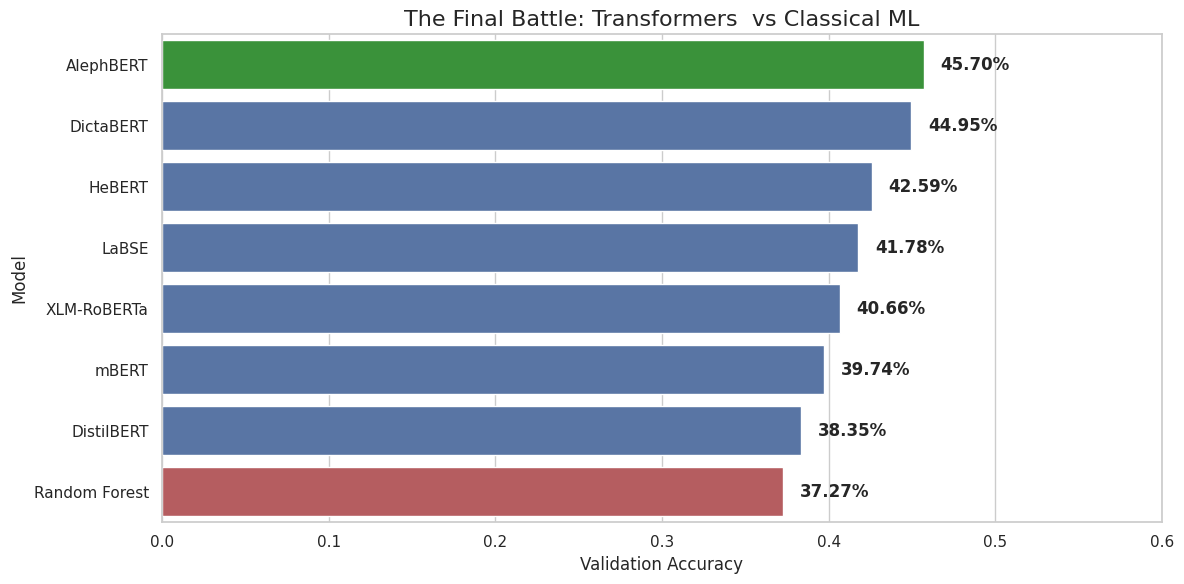


🎉 And the winner is: AlephBERT with 45.70%


In [34]:
# ==========================================
# 8. סיכום סופי והשוואה
# ==========================================
print("\n🏆 --- Final Championship Results (Updated) ---")

# המרת התוצאות לטבלה
df_res = pd.DataFrame(all_results).sort_values(by='Accuracy', ascending=False)

# הוספת ה-Baseline הישן (Random Forest)
rf_row = pd.DataFrame([{'Model': 'Random Forest', 'Accuracy': 0.3727, 'Time': 0, 'Desc': 'Classic ML Baseline'}])
df_final = pd.concat([df_res, rf_row], ignore_index=True).sort_values(by='Accuracy', ascending=False)

print(df_final[['Model', 'Accuracy', 'Desc']])

# ויזואליזציה
plt.figure(figsize=(12, 6))
colors = ['#2ca02c' if 'Aleph' in x else ('#c44e52' if 'Forest' in x else '#4c72b0') for x in df_final['Model']]
sns.barplot(x='Accuracy', y='Model', data=df_final, palette=colors)

plt.title('The Final Battle: Transformers  vs Classical ML', fontsize=16)
plt.xlim(0, 0.6)
plt.xlabel('Validation Accuracy')

# הוספת תוויות
for index, row in df_final.iterrows():
    plt.text(row.Accuracy + 0.01, index, f"{row.Accuracy:.2%}", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

winner = df_final.iloc[0]
print(f"\n🎉 And the winner is: {winner['Model']} with {winner['Accuracy']:.2%}")

<div dir="rtl">

# שלב ח': הפינאלה - אימון המודל הנבחר ומבחן הביצועים הסופי

לאחר השוואת המודלים השונים, הגענו לשלב הסיכום של הפרויקט. בחלק זה אנו "מכתירים" את המודל המנצח — **AlephBERT** — ומבצעים הערכה מעמיקה של יכולותיו.

### מה קורה בתא זה?
1. **Fine-Tuning מלא:** אנו מאמנים את מודל ה-AlephBERT (המאומן מראש על עברית) על מערך הנתונים שלנו למשך 3 מחזורי אימון (Epochs). זהו השלב שבו המודל לומד ספציפית את סגנונות הכתיבה של האמנים שבחרנו.
2. **ניתוח Top-K (עמידות המודל):** במקום לבדוק רק אם המודל צדק ב-100% (Top-1), אנו בודקים גם את הדיוק ב-Top-2 וב-Top-3. מדד זה חשוב במיוחד בעולם השירה, שכן סגנונות כתיבה יכולים להשיק; אנו רוצים לראות אם האמן הנכון נמצא לפחות בין שלוש האפשרויות המובילות של המודל.
3. **מבחן ה-Test Set (רגע האמת):** זהו המבחן הסופי. אנו פותחים את "הכספת" ומריצים את המודל על סט הבדיקה (Test Set) — נתונים שהמודל לא ראה מעולם, לא בשלב האימון ולא בשלב כיוונון הפרמטרים.
4. **דוח סיווג (Classification Report):** הפקת מדדי Precision, Recall ו-F1-Score לכל אמן, כדי לזהות עבור אילו אמנים המודל מתקשה יותר ועבור אילו הוא מצטיין.

<div>



🚀 Starting Final Run with Champion: AlephBERT...
   Training Epoch 1/3...
   Training Epoch 2/3...
   Training Epoch 3/3...

✅ Training complete. Skipping disk save as requested.

🔍 Running Top-K Analysis...

📊 AlephBERT Robustness (Validation):
   Top-1: 44.90%
   Top-2: 69.39%
   Top-3: 82.12%


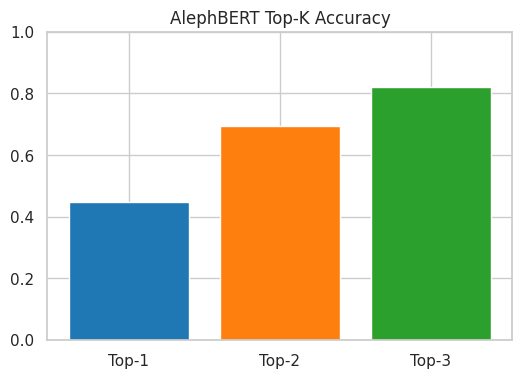


🔓 Unlocking the TEST SET for final evaluation...

🏆 FINAL PROJECT SCORE (AlephBERT): 44.90%
----------------------------------------
              precision    recall  f1-score   support

           0       0.39      0.22      0.28        81
           1       0.44      0.46      0.45       449
           2       0.25      0.21      0.23       136
           3       0.52      0.32      0.40       173
           4       0.38      0.35      0.36       164
           5       0.47      0.56      0.51       463
           6       0.52      0.30      0.38        40
           7       0.17      0.06      0.09        48
           8       0.51      0.64      0.57       308

    accuracy                           0.45      1862
   macro avg       0.41      0.35      0.36      1862
weighted avg       0.44      0.45      0.44      1862

📄 Predictions saved to 'final_project_predictions_alephbert.csv'


In [35]:
# ==========================================
# 8. הפינאלה : אימון המנצח AlephBERT
# ==========================================

# 1. הגדרות המנצח ל-AlephBERT
WINNER_NAME = 'AlephBERT'
WINNER_PATH = 'onlplab/alephbert-base'
EPOCHS = 3
BATCH_SIZE = 16

print(f"🚀 Starting Final Run with Champion: {WINNER_NAME}...")

# 2. אימון מלא מחדש
# ה-AutoTokenizer ידע למשוך את ההגדרות המתאימות ל-AlephBERT באופן אוטומטי
tokenizer = AutoTokenizer.from_pretrained(WINNER_PATH)
model = AutoModelForSequenceClassification.from_pretrained(
    WINNER_PATH,
    num_labels=len(np.unique(y_train)),
    ignore_mismatched_sizes=True
).to(device)

train_ds = LyricsDataset(X_train_txt, y_train, tokenizer, MAX_LEN)
val_ds = LyricsDataset(X_val_txt, y_val, tokenizer, MAX_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

optimizer = AdamW(model.parameters(), lr=2e-5)

# לולאת אימון
for epoch in range(EPOCHS):
    print(f"   Training Epoch {epoch+1}/{EPOCHS}...")
    model.train()
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        outputs.loss.backward()
        optimizer.step()
        optimizer.zero_grad()

print("\n✅ Training complete. Skipping disk save as requested.")

# 3. ניתוח Top-K (עמידות המודל)
print("\n🔍 Running Top-K Analysis...")
k_list = [1, 2, 3]
model.eval()
correct_counts = {k: 0 for k in k_list}
total = 0

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        _, top_indices = torch.topk(logits, k=3, dim=1)

        for k in k_list:
            current_top = top_indices[:, :k]
            matches = current_top.eq(batch['labels'].view(-1, 1).expand_as(current_top))
            correct_counts[k] += matches.sum(dim=1).sum().item()
        total += batch['labels'].size(0)

# הדפסת גרף Top-K
top_k_res = {f'Top-{k}': correct_counts[k]/total for k in k_list}
print(f"\n📊 {WINNER_NAME} Robustness (Validation):")
for k, v in top_k_res.items():
    print(f"   {k}: {v:.2%}")

plt.figure(figsize=(6, 4))
plt.bar(top_k_res.keys(), top_k_res.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title(f'{WINNER_NAME} Top-K Accuracy')
plt.ylim(0, 1)
plt.show()

# 4. רגע האמת: Test Set
print("\n🔓 Unlocking the TEST SET for final evaluation...")
X_test_txt = test_df['clean_text'].values
y_test = test_df['label'].values

test_ds = LyricsDataset(X_test_txt, y_test, tokenizer, MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

all_preds = []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

final_acc = accuracy_score(y_test, all_preds)
print(f"\n🏆 FINAL PROJECT SCORE ({WINNER_NAME}): {final_acc:.2%}")
print("-" * 40)
print(classification_report(y_test, all_preds))

# שמירת התחזיות
test_df['Final_Prediction'] = all_preds
test_df.to_csv('final_project_predictions_alephbert.csv', index=False)
print("📄 Predictions saved to 'final_project_predictions_alephbert.csv'")